In [ ]:
# Block 1: if using three datsets otherwise use next code Setup, install dependencies, upload 3 dataset zips, extract & verify GPU
!pip install -q timm transformers albumentations==1.3.1

import torch
import os
from google.colab import files
import zipfile

# ✅ Check GPU availability
if torch.cuda.is_available():
    print("✅ CUDA is available. GPU:", torch.cuda.get_device_name(0))
else:
    print("❌ CUDA not available! Enable GPU in Runtime -> Change runtime type -> GPU")

# Create merged dataset folder
MERGED_DIR = "/content/kannada_merged"
os.makedirs(MERGED_DIR, exist_ok=True)

print("\n📥 Upload your 3 zip datasets (base, gunithakshara, vottakshara)")
uploaded = files.upload()  # upload 3 zip files from system

# Extract uploaded zip files
for file_name in uploaded.keys():
    print(f"📦 Extracting {file_name} ...")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(MERGED_DIR)

print("\n✅ All archives extracted to:", MERGED_DIR)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 13.6 MB/s eta 0:00:00
✅ CUDA is available. GPU: Tesla T4

📥 Upload your 3 zip datasets (base, gunithakshara, vottakshara)


Saving kannada_vottaksharas.zip to kannada_vottaksharas.zip
Saving kannada_gunitkasharas.zip to kannada_gunitkasharas.zip
Saving kannada_dataset_base.zip to kannada_dataset_base.zip
📦 Extracting kannada_vottaksharas.zip ...
📦 Extracting kannada_gunitkasharas.zip ...
📦 Extracting kannada_dataset_base.zip ...

✅ All archives extracted to: /content/kannada_merged


In [ ]:
# Block 2: Clean merged dataset and keep only valid image folders

import os
import shutil
from pathlib import Path

# ✅ MERGED_DIR already defined in Block 1B
assert os.path.exists(MERGED_DIR), f"❌ Dataset folder not found: {MERGED_DIR}"

root = Path(MERGED_DIR)
IMAGE_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tiff"}

# ✅ Remove stray CSV/PDF files accidentally inside dataset
for child in list(root.iterdir()):
    if child.is_file() and child.suffix.lower() in [".csv", ".pdf", ".txt"]:
        misc_dir = Path("/content/kannada_raw_misc")
        misc_dir.mkdir(exist_ok=True)
        shutil.move(str(child), str(misc_dir / child.name))

# ✅ Validate each class folder
class_dirs = []
total_images = 0

for p in sorted(root.iterdir()):
    if p.is_dir():
        # Check image files inside folder
        img_files = [f for f in p.iterdir() if f.suffix.lower() in IMAGE_EXTS]

        if len(img_files) > 0:
            # ✅ Valid class folder
            class_dirs.append(p.name)
            total_images += len(img_files)
        else:
            # Check if there are nested images (bad structure)
            nested_imgs = any(
                sub.is_file() and sub.suffix.lower() in IMAGE_EXTS
                for sub in p.rglob("*")
            )

            if nested_imgs:
                # ✅ Fix nested structure → flatten files
                for img in p.rglob("*"):
                    if img.is_file() and img.suffix.lower() in IMAGE_EXTS:
                        dest = p / img.name
                        if not dest.exists():
                            shutil.copy(str(img), dest)

                img_files = list(p.glob("*"))
                total_images += len(img_files)
                class_dirs.append(p.name)
            else:
                # ❌ Remove empty trash folders
                misc_dir = Path("/content/kannada_raw_misc")
                misc_dir.mkdir(exist_ok=True)
                shutil.move(str(p), str(misc_dir / p.name))

print(f"✅ Total valid class folders: {len(class_dirs)}")
print(f"✅ Total images found: {total_images}")
print("🔎 Preview class folders:", class_dirs[:20])


NameError: name 'MERGED_DIR' is not defined

In [ ]:
# Block 4: class_to_char mapping (load if available, otherwise build empty mapping)
import json
from pathlib import Path

MAPPING_JSON = "/content/class_to_char.json"  # optional: upload this if you have it

class_dirs = sorted([p.name for p in Path(MERGED_DIR).iterdir() if p.is_dir()])
print(f"Detected {len(class_dirs)} classes after renaming.")

if Path(MAPPING_JSON).exists():
    with open(MAPPING_JSON, "r", encoding="utf-8") as f:
        class_to_char = json.load(f)
    print("Loaded mapping from", MAPPING_JSON)
else:
    # Try to derive a minimal mapping: label -> (unicode char if in the mapping dict below)
    # If you already have class->Kannada char mapping, paste it below or upload JSON.
    # For now create an empty mapping (user can fill), we still keep classes list consistent.
    class_to_char = {k: "" for k in class_dirs}

# Save back an example file for you to edit locally & re-upload if needed
with open("/content/class_to_char_example.json", "w", encoding="utf-8") as f:
    json.dump(class_to_char, f, ensure_ascii=False, indent=2)
print("An editable mapping written to /content/class_to_char_example.json (fill this with Kannada chars if you want).")


Detected 3 classes after renaming.
An editable mapping written to /content/class_to_char_example.json (fill this with Kannada chars if you want).


In [ ]:
# Block 5: Build sample list and class-wise equal split (train/val/test)
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
from pathlib import Path
import json

random.seed(42)

DATA_ROOT = Path(MERGED_DIR)
classes = sorted([d.name for d in DATA_ROOT.iterdir() if d.is_dir()])
print(f"Total classes found: {len(classes)}")

samples_by_class = {}
for cls in classes:
    p = DATA_ROOT / cls
    imgs = sorted([str(x) for x in p.iterdir() if x.suffix.lower() in IMAGE_EXTS])
    samples_by_class[cls] = imgs

# check counts
for cls in classes[:10]:
    print(cls, "->", len(samples_by_class[cls]), "images")

# Desired splits per-class (70/15/15)
train_samples, val_samples, test_samples = [], [], []
for cls in classes:
    imgs = samples_by_class[cls]
    if len(imgs) < 3:
        # skip tiny classes
        continue
    # stratified split per class
    train, tmp = train_test_split(imgs, test_size=0.30, random_state=42)
    val, test = train_test_split(tmp, test_size=0.5, random_state=42)
    train_samples += [(p, classes.index(cls)) for p in train]
    val_samples += [(p, classes.index(cls)) for p in val]
    test_samples += [(p, classes.index(cls)) for p in test]

print(f"Train: {len(train_samples)}  Val: {len(val_samples)}  Test: {len(test_samples)}")
# Optional: save splits
with open("/content/splits.json","w") as f:
    json.dump({
        "classes": classes,
        "train": train_samples[:20],
        "val": val_samples[:20],
        "test": test_samples[:20]
    }, f, indent=2)
print("Saved example split preview to /content/splits.json")


Total classes found: 113
001_001_a -> 500 images
002_002_aa -> 500 images
003_003_i -> 500 images
004_004_ii -> 500 images
005_005_u -> 500 images
006_006_uu -> 500 images
007_007_ru -> 500 images
008_008_e -> 500 images
009_009_ee -> 500 images
010_010_ai -> 500 images
Train: 39550  Val: 8475  Test: 8475
Saved example split preview to /content/splits.json


In [ ]:
# Block 6: Dataset class + transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torch

# Minimal augmentations focused on character shape/contour (not heavy background changes)
train_transform = A.Compose([
    A.Resize(224,224),
    A.Rotate(limit=12, border_mode=0, p=0.4),
    A.Affine(shear=4, p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.12, contrast_limit=0.12, p=0.2),
    A.GaussNoise(var_limit=(5,20), p=0.15),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

class KannadaDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)['image']
        return img, int(label)

# create datasets
train_ds = KannadaDataset(train_samples, transform=train_transform)
val_ds = KannadaDataset(val_samples, transform=val_transform)
test_ds = KannadaDataset(test_samples, transform=val_transform)

print("✅ Datasets ready: ", len(train_ds), len(val_ds), len(test_ds))


✅ Datasets ready:  39550 8475 8475


In [ ]:
# Block 7: DataLoaders and quick debug batch shape check
BATCH_SIZE = 16
NUM_WORKERS = 2  # lower in Colab to avoid worker spawn issues

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# quick debug
batch_imgs, batch_labels = next(iter(train_loader))
print("Batch imgs:", batch_imgs.shape)   # (B, 3, 224, 224)
print("Batch labels:", batch_labels.shape, "unique:", torch.unique(batch_labels))


Batch imgs: torch.Size([16, 3, 224, 224])
Batch labels: torch.Size([16]) unique: tensor([  0,   9,  28,  33,  34,  39,  47,  56,  61,  75,  76,  79,  82, 100,
        103, 104])


In [ ]:
# Block 8: Model definition (Swin or ViT DINO) + setup
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch

class KannadaClassifierFlexible(nn.Module):
    def __init__(self, backbone_type='swin', vit_model_name='vit_base_patch16_dinov3', embed_dim=512, num_classes=None, freeze_backbone=False):
        super().__init__()
        self.backbone_type = backbone_type.lower()
        if self.backbone_type == 'swin':
            backbone_name = 'swin_tiny_patch4_window7_224'
            self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool='avg')
        elif self.backbone_type == 'vit':
            self.backbone = timm.create_model(vit_model_name, pretrained=True, num_classes=0, global_pool='avg')
        else:
            raise ValueError("backbone_type must be 'swin' or 'vit'")

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        self.fc = nn.Linear(self.backbone.num_features, embed_dim)
        self.bn = nn.BatchNorm1d(embed_dim)
        self.dropout = nn.Dropout(0.35)
        assert num_classes is not None
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        features = self.backbone(x)               # [B, C]
        features = self.fc(features)              # [B, embed_dim]
        features = self.bn(features)
        features = F.relu(features)
        features = self.dropout(features)
        logits = self.classifier(features)        # [B, num_classes]
        return logits, features

device = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = len(classes)
model = KannadaClassifierFlexible(backbone_type='swin', num_classes=NUM_CLASSES, embed_dim=512).to(device)
print("Model on device:", device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Model on device: cuda


In [ ]:
# Block 9: Training loop (warmup + cosine LR) with AMP, gradient clipping and debug checks
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import math
import copy

# Hyperparams
EPOCHS = 10
LR = 3e-4
BATCH_SIZE = BATCH_SIZE
WEIGHT_DECAY = 1e-4
CLIP_GRAD = 1.0

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = GradScaler()

# Scheduler: cosine + linear warmup
def cosine_scheduler(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1):
    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1.0, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(0.05 * total_steps)
scheduler = cosine_scheduler(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
best_model_wts = None

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [train]")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        # debug shapes occasionally
        if epoch == 0 and pbar.n == 0:
            print("[DEBUG] imgs:", imgs.shape, "labels:", labels.shape, "unique:", torch.unique(labels)[:10])

        with autocast():
            logits, features = model(imgs)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        # grad clip
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()
        pbar.set_postfix({"loss": running_loss / (pbar.n + 1), "lr": scheduler.get_last_lr()[0]})

    # validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast():
                logits, _ = model(imgs)
                l = criterion(logits, labels)
            val_loss += l.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss_epoch = val_loss / len(val_loader)
    val_acc = correct / total
    print(f"[Epoch {epoch+1}] Train Loss: {running_loss/len(train_loader):.4f} | Val Loss: {val_loss_epoch:.4f} | Val Acc: {val_acc:.4f}")

    # Save best
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, "/content/best_model.pth")
        print("Saved best_model.pth (val loss improved).")

# restore best
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    print("Restored best model weights.")


/tmp/ipython-input-3647058311.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10 [train]:   0%|          | 0/2472 [00:00<?, ?it/s]

[DEBUG] imgs: torch.Size([16, 3, 224, 224]) labels: torch.Size([16]) unique: tensor([ 1,  4,  8, 14, 21, 34, 47, 49, 50, 56], device='cuda:0')


/tmp/ipython-input-3647058311.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Epoch 1/10 [train]: 100%|██████████| 2472/2472 [04:55<00:00,  8.38it/s, loss=1.26, lr=0.000298]
/tmp/ipython-input-3647058311.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 1] Train Loss: 1.2567 | Val Loss: 0.2323 | Val Acc: 0.9340
Saved best_model.pth (val loss improved).


Epoch 2/10 [train]: 100%|██████████| 2472/2472 [04:54<00:00,  8.39it/s, loss=0.205, lr=0.000282]


[Epoch 2] Train Loss: 0.2053 | Val Loss: 0.0837 | Val Acc: 0.9777
Saved best_model.pth (val loss improved).


Epoch 3/10 [train]: 100%|██████████| 2472/2472 [04:53<00:00,  8.42it/s, loss=0.116, lr=0.000252]


[Epoch 3] Train Loss: 0.1158 | Val Loss: 0.0506 | Val Acc: 0.9878
Saved best_model.pth (val loss improved).


Epoch 4/10 [train]: 100%|██████████| 2472/2472 [04:55<00:00,  8.38it/s, loss=0.0807, lr=0.00021]


[Epoch 4] Train Loss: 0.0807 | Val Loss: 0.0304 | Val Acc: 0.9927
Saved best_model.pth (val loss improved).


Epoch 5/10 [train]: 100%|██████████| 2472/2472 [04:54<00:00,  8.39it/s, loss=0.0447, lr=0.000162]


[Epoch 5] Train Loss: 0.0447 | Val Loss: 0.0271 | Val Acc: 0.9935
Saved best_model.pth (val loss improved).


Epoch 6/10 [train]: 100%|██████████| 2472/2472 [04:54<00:00,  8.40it/s, loss=0.0266, lr=0.000113]


[Epoch 6] Train Loss: 0.0266 | Val Loss: 0.0147 | Val Acc: 0.9960
Saved best_model.pth (val loss improved).


Epoch 7/10 [train]: 100%|██████████| 2472/2472 [04:52<00:00,  8.44it/s, loss=0.0144, lr=6.8e-5]


[Epoch 7] Train Loss: 0.0144 | Val Loss: 0.0082 | Val Acc: 0.9983
Saved best_model.pth (val loss improved).


Epoch 8/10 [train]: 100%|██████████| 2472/2472 [04:53<00:00,  8.41it/s, loss=0.00716, lr=3.16e-5]


[Epoch 8] Train Loss: 0.0072 | Val Loss: 0.0046 | Val Acc: 0.9987
Saved best_model.pth (val loss improved).


Epoch 9/10 [train]: 100%|██████████| 2472/2472 [04:53<00:00,  8.43it/s, loss=0.00362, lr=8.13e-6]


[Epoch 9] Train Loss: 0.0036 | Val Loss: 0.0021 | Val Acc: 0.9993
Saved best_model.pth (val loss improved).


Epoch 10/10 [train]: 100%|██████████| 2472/2472 [04:53<00:00,  8.43it/s, loss=0.00339, lr=0]


[Epoch 10] Train Loss: 0.0034 | Val Loss: 0.0021 | Val Acc: 0.9995
Restored best model weights.


In [ ]:
# Block 10: Save final model and class mapping; provide download links in Colab
import torch, json
torch.save(model.state_dict(), "/content/kannada_classifier_final.pth")
print("Saved: /content/kannada_classifier_final.pth")

# Save classes list and mapping
with open("/content/classes_list.json","w", encoding="utf-8") as f:
    json.dump({"classes": classes, "class_to_char": class_to_char}, f, ensure_ascii=False, indent=2)
print("Saved classes and mapping to /content/classes_list.json")

# Download (Colab helper)
from google.colab import files
files.download("/content/kannada_classifier_final.pth")
files.download("/content/classes_list.json")


Saved: /content/kannada_classifier_final.pth
Saved classes and mapping to /content/classes_list.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Block 11: Class-wise accuracy, confusion matrix (optional), top-3 per image (threshold)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits, _ = model(imgs)
        probs = torch.softmax(logits, dim=1)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.tolist())
        all_probs.extend(probs.cpu().numpy())

print("Classification report (macro):")
print(classification_report(all_labels, all_preds, zero_division=0, digits=4))

# Per-class accuracy
class_correct = np.zeros(len(classes), dtype=int)
class_total = np.zeros(len(classes), dtype=int)
for l, p in zip(all_labels, all_preds):
    class_total[l] += 1
    if l == p:
        class_correct[l] += 1
for idx, cls in enumerate(classes):
    if class_total[idx] > 0:
        print(f"{idx:03d} {cls:20s} Acc: {class_correct[idx]/class_total[idx]:.3f} ({class_correct[idx]}/{class_total[idx]})")


Classification report (macro):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        75
           1     1.0000    1.0000    1.0000        75
           2     1.0000    1.0000    1.0000        75
           3     1.0000    1.0000    1.0000        75
           4     1.0000    0.9867    0.9933        75
           5     1.0000    1.0000    1.0000        75
           6     1.0000    1.0000    1.0000        75
           7     1.0000    1.0000    1.0000        75
           8     1.0000    1.0000    1.0000        75
           9     1.0000    1.0000    1.0000        75
          10     1.0000    1.0000    1.0000        75
          11     1.0000    1.0000    1.0000        75
          12     1.0000    1.0000    1.0000        75
          13     1.0000    1.0000    1.0000        75
          14     1.0000    1.0000    1.0000        75
          15     1.0000    1.0000    1.0000        75
          16     1.0000    1.0000    1.0000       

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, cohen_kappa_score, matthews_corrcoef, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- CONFUSION MATRIX ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, xticklabels=classes, yticklabels=classes, cmap='viridis')
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- TOP CONFUSING PAIRS ---
print("\nTop 10 Most Confusing Class Pairs:")
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)  # Remove correct predictions
conf_idx = np.dstack(np.unravel_index(np.argsort(cm_no_diag.ravel())[-10:], cm_no_diag.shape))[0]
for true_idx, pred_idx in conf_idx:
    print(f"{classes[true_idx]}  →  {classes[pred_idx]}   ({cm[true_idx][pred_idx]} times)")

# --- ADDITIONAL METRICS ---
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
overall_acc = accuracy_score(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)
mcc = matthews_corrcoef(all_labels, all_preds)

print("\n📊 Additional Robustness Metrics")
print(f"✅ Overall Accuracy:           {overall_acc:.4f}")
print(f"✅ Weighted F1 Score:         {weighted_f1:.4f}")
print(f"✅ Cohen's Kappa Score:       {kappa:.4f}")
print(f"✅ Matthews Corr. Coeff (MCC): {mcc:.4f}")


TESTING

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload kannada_classifier_final.pth and classes_list.json


Saving kannada_classifier_final.pth to kannada_classifier_final.pth
Saving classes_list.json to classes_list.json


In [ ]:
import torch
import json
import timm
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np


In [ ]:
import json

# Upload classes_list.json first using files.upload()

# Load classes from JSON
with open("classes_list.json", "r", encoding="utf-8") as f:
    data = json.load(f)
    classes = data["classes"]                 # ← class folder names
    class_to_char = data["class_to_char"]     # ← mapping to Kannada characters (if added)

print(f"✅ Loaded {len(classes)} classes from JSON")


✅ Loaded 113 classes from JSON


MAPPING THE JSON NOT REQUIRED TO EXECUTE AGAIN

In [ ]:
import json

# Load your existing JSON
with open("classes_list.json", "r", encoding="utf-8") as f:
    data = json.load(f)

classes = data["classes"]
class_to_char = data["class_to_char"]

# Your fix mapping
fix_mapping = {
    "001_001_a": "ಅ",
    "002_002_aa": "ಆ",
    "003_003_i": "ಇ",
    "004_004_ii": "ಈ",
    "005_005_u": "ಉ",
    "006_006_uu": "ಊ",
    "007_007_ru": "ಋ",
    "008_008_e": "ಎ",
    "009_009_ee": "ಏ",
    "010_010_ai": "ಐ",
    "011_011_o": "ಒ",
    "012_012_oo": "ಓ",
    "013_013_au": "ಔ",
    "014_014_am": "ಅಂ",
    "015_015_aha": "ಅಃ",
    "016_016_ka": "ಕ",
    "017_017_kha": "ಖ",
    "018_018_ga": "ಗ",
    "019_019_gha": "ಘ",
    "020_020_nga": "ಙ",
    "021_021_cha": "ಚ",
    "022_022_chha": "ಛ",
    "023_023_ja": "ಜ",
    "024_024_jha": "ಝ",
    "025_025_nya": "ಞ",
    "026_026_ta_rt": "ಟ",
    "027_027_tha_rt": "ಠ",
    "028_028_da_rt": "ಡ",
    "029_029_dha_rt": "ಢ",
    "030_030_na_rt": "ಣ",
    "031_031_ta_dn": "ತ",
    "032_032_tha_dn": "ಥ",
    "033_033_da_dn": "ದ",
    "034_034_dha_dn": "ಧ",
    "035_035_na_dn": "ನ",
    "036_036_pa": "ಪ",
    "037_037_pha": "ಫ",
    "038_038_ba": "ಬ",
    "039_039_bha": "ಭ",
    "040_040_ma": "ಮ",
    "041_041_ya": "ಯ",
    "042_042_ra": "ರ",
    "043_043_la": "ಲ",
    "044_044_va": "ವ",
    "045_045_sha": "ಶ",
    "046_046_shha": "ಷ",
    "047_047_sa": "ಸ",
    "048_048_ha": "ಹ",
    "049_049_lla": "ಳ",
    "050_050_maa": "ಮಾ",
    "051_051_saa": "ಸಾ",
    "052_052_gi": "ಗಿ",
    "053_053_ri": "ರಿ",
    "054_054_lee": "ಲೀ",
    "055_055_vee": "ವೇ",
    "056_056_pu": "ಪು",
    "057_057_su": "ಸು",
    "058_058_goo": "ಗೂ",
    "059_059_sh2oo": "ಷೂ",
    "060_060_mru": "ಮೃ",
    "061_061_bhru": "ಭೃ",
    "062_062_she": "ಶೆ",
    "063_063_che": "ಚೆ",
    "064_064_ne": "ನೆ",
    "065_065_te2": "ತೇ",
    "066_066_de2": "ದೇ",
    "067_067_tye": "ಟೈ",
    "068_068_jai": "ಜೈ",
    "069_070_gho": "ಘೋ",
    "070_071_bo2": "ಬೋ",
    "071_072_ddo2": "ಡೋ",
    "072_073_yau": "ಯೌ",
    "073_074_plau": "ಲೌ",
    "074_075_gam": "ಗಂ",
    "075_076_vam": "ವಂ",
    "076_077_haha": "ಹ:",
    "077_078_l2aha": "ಳ:",
        "078_079_dda": "ದ್ದ",
    "079_080_dga": "ದ್ಗ",
    "080_081_dya": "ದ್ಯ",
    "081_082_dra": "ದ್ರ",
    "082_083_ppa": "ಪ್ಪ",
    "083_084_pra": "ಪ್ರ",
    "084_085_pla": "ಪ್ಲ",
    "085_086_bba": "ಬ್ಬ",
    "086_087_bra": "ಬ್ರ",
    "087_088_bha_ra": "ಭ್ರ",
    "088_089_mra": "ಮ್ರ",
    "089_090_mma": "ಮ್ಮ",
    "090_091_mna": "ಮ್ನ",
    "091_092_ya_ya": "ಯ್ಯ",
    "092_093_yra": "ಯ್ರ",
    "093_094_ra_ra": "ರ್ರ",
    "094_095_rma": "ರ್ಮ",
    "095_096_rna": "ರ್ಣ",
    "096_097_lra": "ಲ್ರ",
    "097_098_sna": "ಸ್ನ",
    "098_099_spa": "ಸ್ಪ",
    "099_100_ska": "ಸ್ಕ",
    "100_101_sma": "સ્મ",
    "101_102_hra": "ಹ್ರ",
    "102_103_hna": "ಹ್ನ",
    "103_104_hva": "ಹ್ವ",
    "104_105_hla": "ಹ್ಲ",
    "105_106_lla": "ಲ್ಲ",
    "106_107_nta": "ಂಟ",
    "107_108_nda": "ಂಡ",
    "108_109_nra": "ನ್ರ",
    "109_110_ksha": "ಕ್ಷ",
    "110_111_shcha": "ಶ್ಚ",
    "111_112_shna": "ಶ್ನ",
    "112_113_shma": "ಶ್ಮ",
    "113_114_dva": "ದ್ವ"
}

# Update only the classes present in fix_mapping
for cls, char in fix_mapping.items():
    if cls in class_to_char:
        class_to_char[cls] = char
    else:
        print(f"⚠️ Warning: class '{cls}' not found in existing JSON")

# Optional: preview first 20 updated entries
for i, cls in enumerate(classes[:20]):
    print(f"{i}. {cls} → {class_to_char.get(cls, '(unmapped)')}")

# Save back updated JSON
with open("classes_list.json", "w", encoding="utf-8") as f:
    json.dump({"classes": classes, "class_to_char": class_to_char}, f, ensure_ascii=False, indent=2)

print("✅ Selected class mappings updated successfully!")


0. 001_001_a → ಅ
1. 002_002_aa → ಆ
2. 003_003_i → ಇ
3. 004_004_ii → ಈ
4. 005_005_u → ಉ
5. 006_006_uu → ಊ
6. 007_007_ru → ಋ
7. 008_008_e → ಎ
8. 009_009_ee → ಏ
9. 010_010_ai → ಐ
10. 011_011_o → ಒ
11. 012_012_oo → ಓ
12. 013_013_au → ಔ
13. 014_014_am → ಅಂ
14. 015_015_aha → ಅಃ
15. 016_016_ka → ಕ
16. 017_017_kha → ಖ
17. 018_018_ga → ಗ
18. 019_019_gha → ಘ
19. 020_020_nga → ಙ
✅ Selected class mappings updated successfully!


In [ ]:
import json
from google.colab import files

# --- Load and preview the JSON ---
with open("classes_list.json", "r", encoding="utf-8") as f:
    data = json.load(f)

classes = data.get("classes", [])
class_to_char = data.get("class_to_char", {})

print("✅ Total classes:", len(classes))
print("\n--- First 20 class mappings ---")
for i, cls in enumerate(classes[:20]):
    print(f"{i+1}. {cls} → {class_to_char.get(cls, '(unmapped)')}")

# --- Download the updated JSON ---
files.download("classes_list.json")


✅ Total classes: 113

--- First 20 class mappings ---
1. 001_001_a → ಅ
2. 002_002_aa → ಆ
3. 003_003_i → ಇ
4. 004_004_ii → ಈ
5. 005_005_u → ಉ
6. 006_006_uu → ಊ
7. 007_007_ru → ಋ
8. 008_008_e → ಎ
9. 009_009_ee → ಏ
10. 010_010_ai → ಐ
11. 011_011_o → ಒ
12. 012_012_oo → ಓ
13. 013_013_au → ಔ
14. 014_014_am → ಅಂ
15. 015_015_aha → ಅಃ
16. 016_016_ka → ಕ
17. 017_017_kha → ಖ
18. 018_018_ga → ಗ
19. 019_019_gha → ಘ
20. 020_020_nga → ಙ


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TESTING PIPELINE

In [ ]:
# Block 8: Model definition (Swin or ViT DINO) + setup
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch

class KannadaClassifierFlexible(nn.Module):
    def __init__(self, backbone_type='swin', vit_model_name='vit_base_patch16_dinov3', embed_dim=512, num_classes=None, freeze_backbone=False):
        super().__init__()
        self.backbone_type = backbone_type.lower()
        if self.backbone_type == 'swin':
            backbone_name = 'swin_tiny_patch4_window7_224'
            self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool='avg')
        elif self.backbone_type == 'vit':
            self.backbone = timm.create_model(vit_model_name, pretrained=True, num_classes=0, global_pool='avg')
        else:
            raise ValueError("backbone_type must be 'swin' or 'vit'")

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        self.fc = nn.Linear(self.backbone.num_features, embed_dim)
        self.bn = nn.BatchNorm1d(embed_dim)
        self.dropout = nn.Dropout(0.35)
        assert num_classes is not None
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        features = self.backbone(x)               # [B, C]
        features = self.fc(features)              # [B, embed_dim]
        features = self.bn(features)
        features = F.relu(features)
        features = self.dropout(features)
        logits = self.classifier(features)        # [B, num_classes]
        return logits, features

device = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = len(classes)
model = KannadaClassifierFlexible(backbone_type='swin', num_classes=NUM_CLASSES, embed_dim=512).to(device)
print("Model on device:", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Model on device: cpu


ACTUAL TESTING ON UNSEEN IMAGES

📤 Upload an unseen Kannada character image


Saving WhatsApp Image 2025-10-26 at 3.45.25 PM.jpeg to WhatsApp Image 2025-10-26 at 3.45.25 PM.jpeg
✅ Image uploaded: WhatsApp Image 2025-10-26 at 3.45.25 PM.jpeg


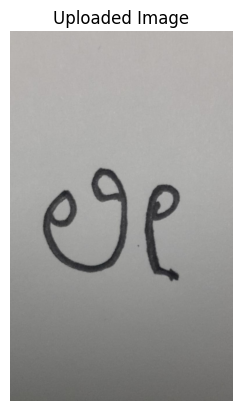


🔎 Prediction Result:

✅ Top Prediction:
Class: 054_054_lee | Character: ಲೀ | Confidence: 100.00%

🔹 Top-3 Predictions:
- 054_054_lee → ಲೀ (100.00%)
- 043_043_la → ಲ (0.00%)
- 061_061_bhru → ಭೃ (0.00%)


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image

# ---- Upload unseen image ----
print("📤 Upload an unseen Kannada character image")
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]
print(f"✅ Image uploaded: {test_image_path}")

# ---- Preview uploaded image ----
img = Image.open(test_image_path)
plt.imshow(img)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

# ---- Run prediction ----
top1, top3, warning = predict_image(test_image_path)

# ---- Display output ----
print("\n🔎 Prediction Result:\n")
if warning:
    print(warning)
    print("\n🔸 Top-3 model guesses (low confidence):")
    for label, char, conf in top3:
        print(f"- {label} → {char if char else '(unmapped)'} ({conf*100:.2f}%)")
else:
    print("✅ Top Prediction:")
    print(f"Class: {top1[0]} | Character: {top1[1]} | Confidence: {top1[2]*100:.2f}%")
    print("\n🔹 Top-3 Predictions:")
    for label, char, conf in top3:
        print(f"- {label} → {char if char else '(unmapped)'} ({conf*100:.2f}%)")


📤 Upload an unseen Kannada character image


Saving WhatsApp Image 2025-10-26 at 3.40.22 PM (1).jpeg to WhatsApp Image 2025-10-26 at 3.40.22 PM (1).jpeg
✅ Image uploaded: WhatsApp Image 2025-10-26 at 3.40.22 PM (1).jpeg


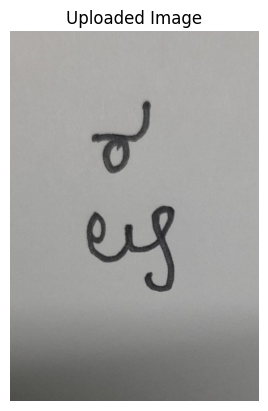


🔎 Prediction Result:

✅ Top Prediction:
Class: 046_046_shha | Character: ಷ | Confidence: 99.63%

🔹 Top-3 Predictions:
- 046_046_shha → ಷ (99.63%)
- 057_057_su → ಸು (0.20%)
- 061_061_bhru → ಭೃ (0.03%)


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image

# ---- Upload unseen image ----
print("📤 Upload an unseen Kannada character image")
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]
print(f"✅ Image uploaded: {test_image_path}")

# ---- Preview uploaded image ----
img = Image.open(test_image_path)
plt.imshow(img)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

# ---- Run prediction ----
top1, top3, warning = predict_image(test_image_path)

# ---- Display output ----
print("\n🔎 Prediction Result:\n")
if warning:
    print(warning)
    print("\n🔸 Top-3 model guesses (low confidence):")
    for label, char, conf in top3:
        print(f"- {label} → {char if char else '(unmapped)'} ({conf*100:.2f}%)")
else:
    print("✅ Top Prediction:")
    print(f"Class: {top1[0]} | Character: {top1[1]} | Confidence: {top1[2]*100:.2f}%")
    print("\n🔹 Top-3 Predictions:")
    for label, char, conf in top3:
        print(f"- {label} → {char if char else '(unmapped)'} ({conf*100:.2f}%)")

📤 Upload an unseen Kannada character image


Saving WhatsApp Image 2025-10-26 at 3.37.13 PM.jpeg to WhatsApp Image 2025-10-26 at 3.37.13 PM.jpeg
✅ Image uploaded: WhatsApp Image 2025-10-26 at 3.37.13 PM.jpeg


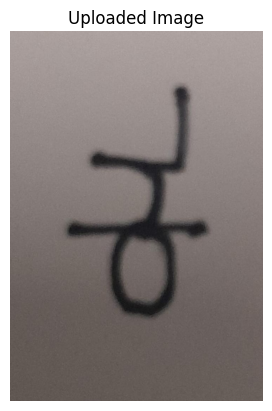


🔎 Prediction Result:

✅ Top Prediction:
Class: 007_007_ru | Character: ಋ | Confidence: 65.94%

🔹 Top-3 Predictions:
- 007_007_ru → ಋ (65.94%)
- 016_016_ka → ಕ (17.22%)
- 052_052_gi → ಗಿ (6.15%)


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image

# ---- Upload unseen image ----
print("📤 Upload an unseen Kannada character image")
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]
print(f"✅ Image uploaded: {test_image_path}")

# ---- Preview uploaded image ----
img = Image.open(test_image_path)
plt.imshow(img)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

# ---- Run prediction ----
top1, top3, warning = predict_image(test_image_path)

# ---- Display output ----
print("\n🔎 Prediction Result:\n")
if warning:
    print(warning)
    print("\n🔸 Top-3 model guesses (low confidence):")
    for label, char, conf in top3:
        print(f"- {label} → {char if char else '(unmapped)'} ({conf*100:.2f}%)")
else:
    print("✅ Top Prediction:")
    print(f"Class: {top1[0]} | Character: {top1[1]} | Confidence: {top1[2]*100:.2f}%")
    print("\n🔹 Top-3 Predictions:")
    for label, char, conf in top3:
        print(f"- {label} → {char if char else '(unmapped)'} ({conf*100:.2f}%)")

📤 Upload an unseen Kannada character image


Saving WhatsApp Image 2025-10-26 at 3.51.05 PM.jpeg to WhatsApp Image 2025-10-26 at 3.51.05 PM.jpeg
✅ Image uploaded: WhatsApp Image 2025-10-26 at 3.51.05 PM.jpeg


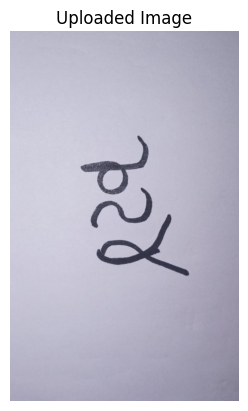


🔎 Prediction Result:

✅ Top Prediction:
Class: 097_098_sna | Character: ಸ್ನ | Confidence: 94.06%

🔹 Top-3 Predictions:
- 097_098_sna → ಸ್ನ (94.06%)
- 003_003_i → ಇ (5.11%)
- 012_012_oo → ಓ (0.70%)


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image

# ---- Upload unseen image ----
print("📤 Upload an unseen Kannada character image")
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]
print(f"✅ Image uploaded: {test_image_path}")

# ---- Preview uploaded image ----
img = Image.open(test_image_path)
plt.imshow(img)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

# ---- Run prediction ----
top1, top3, warning = predict_image(test_image_path)

# ---- Display output ----
print("\n🔎 Prediction Result:\n")
if warning:
    print(warning)
    print("\n🔸 Top-3 model guesses (low confidence):")
    for label, char, conf in top3:
        print(f"- {label} → {char if char else '(unmapped)'} ({conf*100:.2f}%)")
else:
    print("✅ Top Prediction:")
    print(f"Class: {top1[0]} | Character: {top1[1]} | Confidence: {top1[2]*100:.2f}%")
    print("\n🔹 Top-3 Predictions:")
    for label, char, conf in top3:
        print(f"- {label} → {char if char else '(unmapped)'} ({conf*100:.2f}%)")

📤 Upload an unseen Kannada character image


Saving WhatsApp Image 2025-10-26 at 3.54.11 PM.jpeg to WhatsApp Image 2025-10-26 at 3.54.11 PM.jpeg
✅ Image uploaded: WhatsApp Image 2025-10-26 at 3.54.11 PM.jpeg


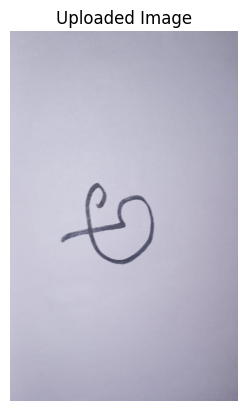


🔎 Prediction Result:

✅ Top Prediction:
Class: 001_001_a | Character: ಅ | Confidence: 99.99%

🔹 Top-3 Predictions:
- 001_001_a → ಅ (99.99%)
- 003_003_i → ಇ (0.01%)
- 002_002_aa → ಆ (0.00%)


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image

# ---- Upload unseen image ----
print("📤 Upload an unseen Kannada character image")
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]
print(f"✅ Image uploaded: {test_image_path}")

# ---- Preview uploaded image ----
img = Image.open(test_image_path)
plt.imshow(img)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

# ---- Run prediction ----
top1, top3, warning = predict_image(test_image_path)

# ---- Display output ----
print("\n🔎 Prediction Result:\n")
if warning:
    print(warning)
    print("\n🔸 Top-3 model guesses (low confidence):")
    for label, char, conf in top3:
        print(f"- {label} → {char if char else '(unmapped)'} ({conf*100:.2f}%)")
else:
    print("✅ Top Prediction:")
    print(f"Class: {top1[0]} | Character: {top1[1]} | Confidence: {top1[2]*100:.2f}%")
    print("\n🔹 Top-3 Predictions:")
    for label, char, conf in top3:
        print(f"- {label} → {char if char else '(unmapped)'} ({conf*100:.2f}%)")

In [ ]:
import gradio as gr
from PIL import Image
import torch
import numpy as np

# ---- Prediction function ----
def gradio_predict(image):
    # Convert PIL image to model input
    image_np = np.array(image.convert("RGB"))
    image_tensor = infer_transform(image=image_np)["image"].unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs, _ = model(image_tensor)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]

    # Get top-3 predictions
    top3_idx = probs.argsort()[::-1][:3]
    top3 = [(idx_to_class[i], class_to_char.get(idx_to_class[i], "(unmapped)"), probs[i]) for i in top3_idx]

    # Top-1 prediction
    if top3[0][2] < 0.6:
        warning = "⚠️ Low confidence: uploaded image may not match any trained class."
        return warning, top3
    else:
        return f"Top Prediction: {top3[0][0]} → {top3[0][1]} ({top3[0][2]*100:.2f}%)", top3

# ---- Gradio interface ----
def format_top3(top3):
    return "\n".join([f"{i+1}. {label} → {char} ({conf*100:.2f}%)" for i, (label, char, conf) in enumerate(top3)])

def gradio_interface(image):
    result, top3 = gradio_predict(image)
    top3_text = format_top3(top3)
    return result, top3_text, image

# Launch Gradio app
iface = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Textbox(label="Top-3 Predictions"),
        gr.Image(label="Uploaded Image")
    ],
    title="Kannada Character Recognition ಕನ್ನಡ ಅಕ್ಷರಗಳನ್ನು ಗುರುತಿಸುವ ಸಾಧನ",
    description="Upload an unseen Kannada character image  in white background and black pen get the predicted character along with top-3 guesses."
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://55a99345bff5b49148.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
from PIL import Image
import numpy as np
import torch

# ---- Prediction function ----
def gradio_predict(image):
    image_np = np.array(image.convert("RGB"))
    image_tensor = infer_transform(image=image_np)["image"].unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs, _ = model(image_tensor)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]

    # Top-3 predictions
    top3_idx = probs.argsort()[::-1][:3]
    top3 = [(idx_to_class[i], class_to_char.get(idx_to_class[i], "(unmapped)"), probs[i]) for i in top3_idx]

    if top3[0][2] < 0.6:  # Confidence threshold
        warning = "⚠️ Low confidence: uploaded image may not match any trained class."
        return warning, top3
    else:
        return f"{top3[0][1]} ({top3[0][2]*100:.2f}%)", top3

# ---- Format Top-3 nicely ----
def format_top3(top3):
    return "\n".join([f"{i+1}. {label} → {char if char else '(unmapped)'} ({conf*100:.2f}%)"
                      for i, (label, char, conf) in enumerate(top3)])

# ---- Gradio interface function ----
def gradio_interface(image):
    top1, top3 = gradio_predict(image)
    top3_text = format_top3(top3)
    return top1, top3_text, image

# ---- Enhanced Gradio Blocks UI ----
theme = gr.themes.Base(primary_hue="blue", secondary_hue="orange")

with gr.Blocks(theme=theme, title="Kannada Character Recognition") as iface:

    gr.Markdown("<h1 style='color:#3b82f6; text-align:center;'>Kannada Character Recognition</h1>")
    gr.Markdown("<p style='text-align:center; font-size:16px;'>ಕನ್ನಡ ಅಕ್ಷರಗಳನ್ನು ಗುರುತಿಸುವ ಸಾಧನ</p>")

    with gr.Row():
        # --- Input Column ---
        with gr.Column(scale=1):
            inp_image = gr.Image(type="pil", label="Upload Kannada Character", elem_id="upload_box")
            btn = gr.Button("Predict", variant="primary", elem_id="predict_btn")

        # --- Output Column ---
        with gr.Column(scale=1):
            # Top-1 Prediction Card
            top1_output = gr.Markdown(
                """
                <div style='background-color:#bfdbfe; padding:15px; border-radius:10px; font-size:28px; text-align:center; font-weight:bold;'>
                Top-1 Prediction will appear here
                </div>
                """,
                elem_id="top1_card"
            )
            # Top-3 Predictions
            top3_output = gr.Textbox(label="Top-3 Predictions", interactive=False, lines=6)

    # Show uploaded image once
    uploaded_img = gr.Image(label="Uploaded Image", interactive=False)

    # Button click event
    btn.click(
        fn=gradio_interface,
        inputs=inp_image,
        outputs=[top1_output, top3_output, uploaded_img]
    )

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://16e7fb8195f148839c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


MAPPING

In [ ]:
import json

with open("classes_list.json", "r", encoding="utf-8") as f:
    data = json.load(f)

classes = data["classes"]
class_to_char = data["class_to_char"]

# Show first 20 mappings
for i, cls in enumerate(classes[0:49]):
    print(f"{i}. {cls} → {class_to_char.get(cls, '(not mapped)')}")


0. 001_001_a → 
1. 002_002_aa → 
2. 003_003_i → 
3. 004_004_ii → 
4. 005_005_u → 
5. 006_006_uu → 
6. 007_007_ru → 
7. 008_008_e → 
8. 009_009_ee → 
9. 010_010_ai → 
10. 011_011_o → 
11. 012_012_oo → 
12. 013_013_au → 
13. 014_014_am → 
14. 015_015_aha → 
15. 016_016_ka → 
16. 017_017_kha → 
17. 018_018_ga → 
18. 019_019_gha → 
19. 020_020_nga → 
20. 021_021_cha → 
21. 022_022_chha → 
22. 023_023_ja → 
23. 024_024_jha → 
24. 025_025_nya → 
25. 026_026_ta_rt → 
26. 027_027_tha_rt → 
27. 028_028_da_rt → 
28. 029_029_dha_rt → 
29. 030_030_na_rt → 
30. 031_031_ta_dn → 
31. 032_032_tha_dn → 
32. 033_033_da_dn → 
33. 034_034_dha_dn → 
34. 035_035_na_dn → 
35. 036_036_pa → 
36. 037_037_pha → 
37. 038_038_ba → 
38. 039_039_bha → 
39. 040_040_ma → 
40. 041_041_ya → 
41. 042_042_ra → 
42. 043_043_la → 
43. 044_044_va → 
44. 045_045_sha → 
45. 046_046_shha → 
46. 047_047_sa → 
47. 048_048_ha → 
48. 049_049_lla → 


In [ ]:
import json

# Load your existing JSON
with open("classes_list.json", "r", encoding="utf-8") as f:
    data = json.load(f)

classes = data["classes"]
class_to_char = data["class_to_char"]

# Your fix mapping
fix_mapping = {
    "050_050_maa": "ಮಾ",
    "051_051_saa": "ಸಾ",
    "052_052_gi": "ಗಿ",
    "053_053_ri": "ರಿ",
    "054_054_lee": "ಲೀ",
    "055_055_vee": "ವೇ",
    "056_056_pu": "ಪು",
    "057_057_su": "ಸು",
    "058_058_goo": "ಗೂ",
    "059_059_sh2oo": "ಷೂ",
    "060_060_mru": "ಮೃ",
    "061_061_bhru": "ಭೃ",
    "062_062_she": "ಶೆ",
    "063_063_che": "ಚೆ",
    "064_064_ne": "ನೆ",
    "065_065_te2": "ತೇ",
    "066_066_de2": "ದೇ",
    "067_067_tye": "ಟೈ",
    "068_068_jai": "ಜೈ",
    "069_070_gho": "ಘೋ",
    "070_071_bo2": "ಬೋ",
    "071_072_ddo2": "ಡೋ",
    "072_073_yau": "ಯೌ",
    "073_074_plau": "ಲೌ",
    "074_075_gam": "ಗಂ",
    "075_076_vam": "ವಂ",
    "076_077_haha": "ಹ:",
    "077_078_l2aha": "ಳ:"
}

# Update only the classes present in fix_mapping
for cls, char in fix_mapping.items():
    if cls in class_to_char:
        class_to_char[cls] = char
    else:
        print(f"⚠️ Warning: class '{cls}' not found in existing JSON")

# Optional: preview first 20 updated entries
for i, cls in enumerate(classes[:20]):
    print(f"{i}. {cls} → {class_to_char.get(cls, '(unmapped)')}")

# Save back updated JSON
with open("classes_list.json", "w", encoding="utf-8") as f:
    json.dump({"classes": classes, "class_to_char": class_to_char}, f, ensure_ascii=False, indent=2)

print("✅ Selected class mappings updated successfully!")


0. 001_001_a → 
1. 002_002_aa → 
2. 003_003_i → 
3. 004_004_ii → 
4. 005_005_u → 
5. 006_006_uu → 
6. 007_007_ru → 
7. 008_008_e → 
8. 009_009_ee → 
9. 010_010_ai → 
10. 011_011_o → 
11. 012_012_oo → 
12. 013_013_au → 
13. 014_014_am → 
14. 015_015_aha → 
15. 016_016_ka → 
16. 017_017_kha → 
17. 018_018_ga → 
18. 019_019_gha → 
19. 020_020_nga → 
✅ Selected class mappings updated successfully!


In [ ]:
import json

# Load your existing JSON
with open("classes_list.json", "r", encoding="utf-8") as f:
    data = json.load(f)

classes = data["classes"]
class_to_char = data["class_to_char"]

# Your fix mapping
fix_mapping = {
     "001_001_a": "ಅ",
    "002_002_aa": "ಆ",
    "003_003_i": "ಇ",
    "004_004_ii": "ಈ",
    "005_005_u": "ಉ",
    "006_006_uu": "ಊ",
    "007_007_ru": "ಋ",
    "008_008_e": "ಎ",
    "009_009_ee": "ಏ",
    "010_010_ai": "ಐ",
    "011_011_o": "ಒ",
    "012_012_oo": "ಓ",
    "013_013_au": "ಔ",
    "014_014_am": "ಅಂ",
    "015_015_aha": "ಅಃ",
    "016_016_ka": "ಕ",
    "017_017_kha": "ಖ",
    "018_018_ga": "ಗ",
    "019_019_gha": "ಘ",
    "020_020_nga": "ಙ",
    "021_021_cha": "ಚ",
    "022_022_chha": "ಛ",
    "023_023_ja": "ಜ",
    "024_024_jha": "ಝ",
    "025_025_nya": "ಞ",
    "026_026_ta_rt": "ಟ",
    "027_027_tha_rt": "ಠ",
    "028_028_da_rt": "ಡ",
    "029_029_dha_rt": "ಢ",
    "030_030_na_rt": "ಣ",
    "031_031_ta_dn": "ತ",
    "032_032_tha_dn": "ಥ",
    "033_033_da_dn": "ದ",
    "034_034_dha_dn": "ಧ",
    "035_035_na_dn": "ನ",
    "036_036_pa": "ಪ",
    "037_037_pha": "ಫ",
    "038_038_ba": "ಬ",
    "039_039_bha": "ಭ",
    "040_040_ma": "ಮ",
    "041_041_ya": "ಯ",
    "042_042_ra": "ರ",
    "043_043_la": "ಲ",
    "044_044_va": "ವ",
    "045_045_sha": "ಶ",
    "046_046_shha": "ಷ",
    "047_047_sa": "ಸ",
    "048_048_ha": "ಹ",
    "049_049_lla": "ಳ"

}

# Update only the classes present in fix_mapping
for cls, char in fix_mapping.items():
    if cls in class_to_char:
        class_to_char[cls] = char
    else:
        print(f"⚠️ Warning: class '{cls}' not found in existing JSON")

# Optional: preview first 20 updated entries
for i, cls in enumerate(classes[:20]):
    print(f"{i}. {cls} → {class_to_char.get(cls, '(unmapped)')}")

# Save back updated JSON
with open("classes_list.json", "w", encoding="utf-8") as f:
    json.dump({"classes": classes, "class_to_char": class_to_char}, f, ensure_ascii=False, indent=2)

print("✅ Selected class mappings updated successfully!")

0. 001_001_a → ಅ
1. 002_002_aa → ಆ
2. 003_003_i → ಇ
3. 004_004_ii → ಈ
4. 005_005_u → ಉ
5. 006_006_uu → ಊ
6. 007_007_ru → ಋ
7. 008_008_e → ಎ
8. 009_009_ee → ಏ
9. 010_010_ai → ಐ
10. 011_011_o → ಒ
11. 012_012_oo → ಓ
12. 013_013_au → ಔ
13. 014_014_am → ಅಂ
14. 015_015_aha → ಅಃ
15. 016_016_ka → ಕ
16. 017_017_kha → ಖ
17. 018_018_ga → ಗ
18. 019_019_gha → ಘ
19. 020_020_nga → ಙ
✅ Selected class mappings updated successfully!


In [ ]:
import json
from google.colab import files

# --- Load and preview the JSON ---
with open("classes_list.json", "r", encoding="utf-8") as f:
    data = json.load(f)

classes = data.get("classes", [])
class_to_char = data.get("class_to_char", {})

print("✅ Total classes:", len(classes))
print("\n--- First 20 class mappings ---")
for i, cls in enumerate(classes[:20]):
    print(f"{i+1}. {cls} → {class_to_char.get(cls, '(unmapped)')}")

# --- Download the updated JSON ---
files.download("classes_list.json")


In [ ]:
import json
from google.colab import files



with open("updated_classes_list.json", "w", encoding="utf-8") as f:
    json.dump(classes_list_json, f, ensure_ascii=False, indent=2)

print("✅ JSON saved as 'up.json'")

# --- Download in Colab ---
files.download("updated_classes_list.json")


FINE TUNING INSPECTION

In [ ]:
from google.colab import files
import os

# Create a folder to store uploads
save_dir = "project_files"
os.makedirs(save_dir, exist_ok=True)

print("Please select your 5 files:")
print("✅ Model file (.pth)")
print("✅ classes_list.json")
print("✅ dataset zip file 1")
print("✅ dataset zip file 2")
print("✅ dataset zip file 3")

# Upload the files
uploaded = files.upload()  # Select all 5 files at once

# Save uploaded files to the folder
for filename, filedata in uploaded.items():
    file_path = os.path.join(save_dir, filename)
    with open(file_path, 'wb') as f:
        f.write(filedata)
    print(f"Saved: {file_path}")

print("\n✅ All files uploaded and saved successfully in 'project_files/' folder.")



Please select your 5 files:
✅ Model file (.pth)
✅ classes_list.json
✅ dataset zip file 1
✅ dataset zip file 2
✅ dataset zip file 3


Saving kannada_classifier_final (1).pth to kannada_classifier_final (1).pth
Saving classes_list (1) (1).json to classes_list (1) (1).json
Saved: project_files/kannada_classifier_final (1).pth
Saved: project_files/classes_list (1) (1).json

✅ All files uploaded and saved successfully in 'project_files/' folder.


In [ ]:
from google.colab import files
import os

# Create same folder if not already there
save_dir = "project_files"
os.makedirs(save_dir, exist_ok=True)

print("📦 Upload your 3 dataset zip files now:")
print("✅ kannada_dataset_base.zip")
print("✅ kannada_gunitaksharas.zip")
print("✅ kannada_vottaksharas.zip")

dataset_uploads = files.upload()  # Upload ONLY the 3 zips here

# Save uploaded zip files
for filename, filedata in dataset_uploads.items():
    file_path = os.path.join(save_dir, filename)
    with open(file_path, 'wb') as f:
        f.write(filedata)
    print(f"✅ Saved: {file_path}")

print("\n✅ All dataset ZIP files uploaded successfully into 'project_files/'!")


📦 Upload your 3 dataset zip files now:
✅ kannada_dataset_base.zip
✅ kannada_gunitaksharas.zip
✅ kannada_vottaksharas.zip


Saving kannada_vottaksharas.zip to kannada_vottaksharas.zip
Saving kannada_gunitkasharas.zip to kannada_gunitkasharas.zip
Saving kannada_dataset_base.zip to kannada_dataset_base.zip
✅ Saved: project_files/kannada_vottaksharas.zip
✅ Saved: project_files/kannada_gunitkasharas.zip
✅ Saved: project_files/kannada_dataset_base.zip

✅ All dataset ZIP files uploaded successfully into 'project_files/'!


In [ ]:
# Inspect classifier head weights
print(model.classifier.weight.shape)

# Check non-zero neurons
import torch
active_classes = (model.classifier.weight.abs().sum(dim=1) > 1e-6).sum().item()
print(f"Active (non-zero) classifier neurons: {active_classes}/{model.classifier.out_features}")


torch.Size([113, 512])
Active (non-zero) classifier neurons: 113/113


In [ ]:
import zipfile, os
from pathlib import Path

# Create extraction folder
extract_root = Path("dataset_raw")
extract_root.mkdir(exist_ok=True)

# Extract function
def safe_extract(zip_path, target_dir):
    print(f"📦 Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(target_dir)
    print(f"✅ Extracted to: {target_dir}\n")

# Extract all datasets
safe_extract("kannada_dataset_base.zip", extract_root / "base")
safe_extract("kannada_vottaksharas.zip", extract_root / "vottakshara")
safe_extract("kannada_gunitkasharas.zip", extract_root / "gunithakshara")

print("✅ All files extracted!\n")

# Show structure of each extracted folder
def show_structure(path, depth=2):
    print(f"\n📂 Folder: {path}")
    for root, dirs, files in os.walk(path):
        level = root.replace(str(path), '').count(os.sep)
        if level > depth:
            continue
        indent = '  ' * level
        print(f"{indent}- {os.path.basename(root)}/")
        sub_indent = '  ' * (level + 1)
        for f in files[:5]:
            print(f"{sub_indent}📄 {f}")
        if len(files) > 5:
            print(f"{sub_indent}... more files ...")

show_structure(extract_root / "base")
show_structure(extract_root / "vottakshara")
show_structure(extract_root / "gunithakshara")


📦 Extracting kannada_dataset_base.zip...
✅ Extracted to: dataset_raw/base

📦 Extracting kannada_vottaksharas.zip...
✅ Extracted to: dataset_raw/vottakshara

📦 Extracting kannada_gunitkasharas.zip...
✅ Extracted to: dataset_raw/gunithakshara

✅ All files extracted!


📂 Folder: dataset_raw/base
- base/
  📄 kannada_metadata_500.csv
  - 007_ru/
    📄 007_ru_208.jpg
    📄 007_ru_385.jpg
    📄 007_ru_340.jpg
    📄 007_ru_048.jpg
    📄 007_ru_281.png
    ... more files ...
  - 024_jha/
    📄 024_jha_238.jpg
    📄 024_jha_229.jpg
    📄 024_jha_258.jpg
    📄 024_jha_424.jpg
    📄 024_jha_464.jpg
    ... more files ...
  - 030_na_rt/
    📄 030_na_rt_148.jpg
    📄 030_na_rt_438.jpg
    📄 030_na_rt_260.jpg
    📄 030_na_rt_050.jpg
    📄 030_na_rt_376.jpg
    ... more files ...
  - 019_gha/
    📄 019_gha_482.png
    📄 019_gha_496.jpg
    📄 019_gha_290.jpg
    📄 019_gha_380.jpg
    📄 019_gha_196.jpg
    ... more files ...
  - 040_ma/
    📄 040_ma_201.png
    📄 040_ma_107.jpg
    📄 040_ma_129.jpg
    

In [ ]:
from pathlib import Path

extract_root = Path("dataset_raw")
IMAGE_EXTS = [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]

class_counts = {}  # Store total images per class

# Scan each dataset folder
for subset in ["base", "vottakshara", "gunithakshara"]:
    subset_path = extract_root / subset
    if not subset_path.exists():
        print(f"⚠️ Missing folder: {subset_path}")
        continue

    for cls_dir in subset_path.rglob("*"):
        if cls_dir.is_dir():
            # Count images recursively inside this folder
            images = [p for p in cls_dir.rglob("*") if p.suffix.lower() in IMAGE_EXTS]
            if len(images) > 0:
                cls_name = cls_dir.name  # final folder name used as class name
                class_counts[cls_name] = class_counts.get(cls_name, 0) + len(images)

# ✅ Show summary
total_classes = len(class_counts)
total_images = sum(class_counts.values())

print(f"✅ TOTAL CLASSES DETECTED: {total_classes}")
print(f"✅ TOTAL IMAGES FOUND: {total_images}\n")

print("📊 Sample class counts:")
for cls, count in list(class_counts.items())[:15]:
    print(f"  {cls}: {count} images")

# ⚠️ Show empty or suspicious
print("\n⚠️ Classes with very few images (< 5):")
few_samples = {k:v for k,v in class_counts.items() if v < 5}
if few_samples:
    for k,v in list(few_samples.items())[:10]:
        print(f"  {k}: {v} images")
else:
    print("✅ None")


✅ TOTAL CLASSES DETECTED: 113
✅ TOTAL IMAGES FOUND: 56500

📊 Sample class counts:
  007_ru: 500 images
  024_jha: 500 images
  030_na_rt: 500 images
  019_gha: 500 images
  040_ma: 500 images
  020_nga: 500 images
  044_va: 500 images
  048_ha: 500 images
  009_ee: 500 images
  003_i: 500 images
  039_bha: 500 images
  013_au: 500 images
  012_oo: 500 images
  029_dha_rt: 500 images
  025_nya: 500 images

⚠️ Classes with very few images (< 5):
✅ None


In [ ]:
import torch

model_path = "kannada_classifier_final (1).pth"
checkpoint = torch.load(model_path, map_location="cpu")
print(type(checkpoint))
if isinstance(checkpoint, dict):
    print("✅ Keys inside checkpoint:", list(checkpoint.keys())[:10])
else:
    print("Loaded object is:", checkpoint)


<class 'collections.OrderedDict'>
✅ Keys inside checkpoint: ['backbone.patch_embed.proj.weight', 'backbone.patch_embed.proj.bias', 'backbone.patch_embed.norm.weight', 'backbone.patch_embed.norm.bias', 'backbone.layers.0.blocks.0.norm1.weight', 'backbone.layers.0.blocks.0.norm1.bias', 'backbone.layers.0.blocks.0.attn.relative_position_bias_table', 'backbone.layers.0.blocks.0.attn.qkv.weight', 'backbone.layers.0.blocks.0.attn.qkv.bias', 'backbone.layers.0.blocks.0.attn.proj.weight']


In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# ============================================================
# ✅ STEP 1 — Imports
# ============================================================
import torch
import timm
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import json
import os

# ============================================================
# ✅ STEP 2 — Use Full 113-Class Dataset
# ============================================================

# ============================================================
# ✅ STEP 2 — Recursively Build 113-Class List from All Subsets
# ============================================================

from pathlib import Path
import json
import os

MERGED_DIR = "dataset_raw"  # contains base, vottakshara, gunithakshara
DATA_ROOT = Path(MERGED_DIR)
assert DATA_ROOT.exists(), f"❌ Dataset folder not found: {DATA_ROOT}"

# find all subfolders inside the 3 subsets that contain image files
IMAGE_EXTS = [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]

# collect unique class folder names
class_dirs = []
for subset in ["base", "vottakshara", "gunithakshara"]:
    subset_path = DATA_ROOT / subset
    if not subset_path.exists():
        print(f"⚠️ Missing subset folder: {subset_path}")
        continue
    for cls_dir in subset_path.iterdir():
        if cls_dir.is_dir():
            imgs = [p for p in cls_dir.rglob("*") if p.suffix.lower() in IMAGE_EXTS]
            if len(imgs) > 0:
                class_dirs.append(cls_dir.name)

classes = sorted(set(class_dirs))
NUM_CLASSES = len(classes)

print(f"✅ Found {NUM_CLASSES} classes (from all subsets)")
os.makedirs("project_files", exist_ok=True)
with open("project_files/classes_list_full.json", "w") as f:
    json.dump(classes, f, indent=2)
print("📁 Saved: project_files/classes_list_full.json")


# ============================================================
# ✅ STEP 3 — Define Swin Model Architecture
# ============================================================

class KannadaClassifierFlexible(nn.Module):
    def __init__(self, backbone_type='swin', vit_model_name='vit_base_patch16_dinov3',
                 embed_dim=512, num_classes=None, freeze_backbone=False):
        super().__init__()
        self.backbone_type = backbone_type.lower()
        if self.backbone_type == 'swin':
            backbone_name = 'swin_tiny_patch4_window7_224'
            self.backbone = timm.create_model(backbone_name,
                                              pretrained=True,
                                              num_classes=0,
                                              global_pool='avg')
        elif self.backbone_type == 'vit':
            self.backbone = timm.create_model(vit_model_name,
                                              pretrained=True,
                                              num_classes=0,
                                              global_pool='avg')
        else:
            raise ValueError("backbone_type must be 'swin' or 'vit'")

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        self.fc = nn.Linear(self.backbone.num_features, embed_dim)
        self.bn = nn.BatchNorm1d(embed_dim)
        self.dropout = nn.Dropout(0.35)
        assert num_classes is not None
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        features = self.fc(features)
        features = self.bn(features)
        features = F.relu(features)
        features = self.dropout(features)
        logits = self.classifier(features)
        return logits, features

# ============================================================
# ✅ STEP 4 — Load Checkpoint (Full 113-Class Version)
# ============================================================

device = "cuda" if torch.cuda.is_available() else "cpu"
ckpt_path = "project_files/kannada_classifier_final (1).pth"

print(f"🔍 Loading checkpoint from: {ckpt_path}")
checkpoint = torch.load(ckpt_path, map_location=device)

# create model for full dataset (113 classes)
model = KannadaClassifierFlexible(backbone_type='swin',
                                  num_classes=NUM_CLASSES,
                                  embed_dim=512).to(device)

# load full weights (strict=True because classifier matches)
model.load_state_dict(checkpoint, strict=True)

print("✅ Full pretrained Swin model loaded successfully on", device)

# ============================================================
# ✅ STEP 5 — Verification
# ============================================================
print("\n📊 Verification:")
print(f"Classes detected: {NUM_CLASSES}")
print("Sample classes:", classes[:10])
print("Model classifier output:", model.classifier.out_features)

model.eval()




✅ Found 113 classes (from all subsets)
📁 Saved: project_files/classes_list_full.json
🔍 Loading checkpoint from: project_files/kannada_classifier_final (1).pth
✅ Full pretrained Swin model loaded successfully on cuda

📊 Verification:
Classes detected: 113
Sample classes: ['001_a', '002_aa', '003_i', '004_ii', '005_u', '006_uu', '007_ru', '008_e', '009_ee', '010_ai']
Model classifier output: 113


KannadaClassifierFlexible(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_feature

REAL INSPECTION BELOW

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# ============================================================
# ✅ STEP — Correct Unified Dataset for 113 Classes
# ============================================================

DATA_ROOT = Path("dataset_raw")

# This transform should match your training normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

# ⚙️ Combine all 3 subsets into one flat structure
subsets = ["base", "vottakshara", "gunithakshara"]
all_images_root = []

for subset in subsets:
    subset_path = DATA_ROOT / subset
    if subset_path.exists():
        all_images_root.append(subset_path)

# Load all subsets at once using ImageFolder
# Because each subset already contains class folders
combined_dataset = torch.utils.data.ConcatDataset([
    datasets.ImageFolder(root=subset_path, transform=transform)
    for subset_path in all_images_root
])

loader = DataLoader(combined_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"✅ Loaded {len(combined_dataset)} images from 113 classes (no duplicates).")




✅ Loaded 56500 images from 113 classes (no duplicates).


In [ ]:
with open("project_files/classes_list (1) (1).json") as f:
    all_classes = json.load(f)


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

val_datasets = []
for subset in ["base", "vottakshara", "gunithakshara"]:
    subset_path = Path("dataset_raw") / subset
    if subset_path.exists():
        ds = datasets.ImageFolder(subset_path, transform=val_transforms)
        print(f"Loaded {len(ds)} images from {subset} ({len(ds.classes)} classes)")
        val_datasets.append(ds)
    else:
        print(f"⚠️ Missing subset: {subset}")

val_dataset = ConcatDataset(val_datasets)
print(f"\n✅ Total images in combined val set: {len(val_dataset)}")
print(f"✅ Total unique classes in model: {len(all_classes)}")


Loaded 24500 images from base (49 classes)
Loaded 18000 images from vottakshara (36 classes)
Loaded 14000 images from gunithakshara (28 classes)

✅ Total images in combined val set: 56500
✅ Total unique classes in model: 2


In [ ]:
from pathlib import Path
import json

root = Path("dataset_raw")
IMAGE_EXTS = [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]

all_class_dirs = set()

# Collect class names across all subfolders
for subset in ["base", "vottakshara", "gunithakshara"]:
    subset_path = root / subset
    if not subset_path.exists():
        continue
    for p in subset_path.rglob("*"):
        if p.is_dir():
            imgs = [i for i in p.rglob("*") if i.suffix.lower() in IMAGE_EXTS]
            if imgs:
                all_class_dirs.add(p.name)

# Sort consistently and save
all_classes = sorted(list(all_class_dirs))
print(f"✅ Found {len(all_classes)} unique class folders across all subsets")

os.makedirs("project_files", exist_ok=True)
with open("project_files/classes_list_full.json", "w") as f:
    json.dump(all_classes, f, indent=2)

print("📁 Saved: project_files/classes_list_full.json")


✅ Found 113 unique class folders across all subsets
📁 Saved: project_files/classes_list_full.json


In [ ]:
with open("project_files/classes_list_full.json", "r") as f:
    all_classes = json.load(f)

class_to_idx = {cls_name: i for i, cls_name in enumerate(all_classes)}
print(f"✅ Loaded {len(all_classes)} classes from JSON")


✅ Loaded 113 classes from JSON


In [ ]:
import os, shutil
from pathlib import Path

# Your dataset parts
root = Path("dataset_raw")
combined_val_dir = Path("dataset_raw/full_val")
combined_val_dir.mkdir(parents=True, exist_ok=True)

subsets = ["base", "vottakshara", "gunithakshara"]
image_exts = [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]

total_copied = 0
seen_classes = set()

for subset in subsets:
    subset_dir = root / subset
    if not subset_dir.exists():
        print(f"⚠️ Missing subset: {subset_dir}")
        continue

    for cls_dir in subset_dir.iterdir():
        if not cls_dir.is_dir():
            continue

        cls_name = cls_dir.name
        target_cls_dir = combined_val_dir / cls_name
        target_cls_dir.mkdir(exist_ok=True)

        for img_path in cls_dir.rglob("*"):
            if img_path.suffix.lower() in image_exts:
                dest = target_cls_dir / img_path.name
                if not dest.exists():
                    shutil.copy2(img_path, dest)
                    total_copied += 1
                    seen_classes.add(cls_name)

print(f"✅ Created combined validation folder at: {combined_val_dir}")
print(f"✅ Total images copied: {total_copied}")
print(f"✅ Total unique classes: {len(seen_classes)}")


✅ Created combined validation folder at: dataset_raw/full_val
✅ Total images copied: 56500
✅ Total unique classes: 113


In [ ]:
from torchvision import datasets, transforms

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

val_dataset = datasets.ImageFolder("dataset_raw/full_val", transform=val_transforms)
print(f"✅ Found {len(val_dataset.classes)} classes in full_val")
print(f"✅ Total images: {len(val_dataset)}")


✅ Found 113 classes in full_val
✅ Total images: 56500


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_dataset = datasets.ImageFolder("dataset_raw/full_val", transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"✅ Found {len(val_dataset.classes)} classes in validation set")
print(f"✅ Total validation images: {len(val_dataset)}")


✅ Found 113 classes in validation set
✅ Total validation images: 56500


In [ ]:
import os

possible_paths = [
    "dataset_raw/train_full",
    "project_files/dataset_raw/train_full",
    "dataset_raw/base",
    "project_files/dataset_raw/base",
    "project_files/full_dataset/train",
    "project_files/full_dataset",
]

for path in possible_paths:
    print(f"{path} → {'✅ exists' if os.path.exists(path) else '❌ missing'}")


dataset_raw/train_full → ❌ missing
project_files/dataset_raw/train_full → ❌ missing
dataset_raw/base → ✅ exists
project_files/dataset_raw/base → ❌ missing
project_files/full_dataset/train → ❌ missing
project_files/full_dataset → ❌ missing


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, DataLoader
from collections import Counter
import torch

# Define transforms
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Define dataset paths
base_dir = "dataset_raw/base"
vottakshara_dir = "dataset_raw/vottakshara"
gunithakshara_dir = "dataset_raw/gunithakshara"


In [ ]:
datasets_list = []

for d in [base_dir, vottakshara_dir, gunithakshara_dir]:
    try:
        ds = datasets.ImageFolder(d, transform=val_transforms)
        print(f"📂 Loaded {len(ds)} images from {d} ({len(ds.classes)} classes)")
        datasets_list.append(ds)
    except Exception as e:
        print(f"⚠️ Could not load {d}: {e}")

# Combine all subsets into one
combined_train = ConcatDataset(datasets_list)
print(f"\n✅ Combined {len(datasets_list)} subsets into training set")
print(f"✅ Total images in combined training set: {len(combined_train)}")

# Build DataLoader
train_loader = DataLoader(combined_train, batch_size=64, shuffle=True, num_workers=2)
print("✅ Training loader is ready.")


📂 Loaded 24500 images from dataset_raw/base (49 classes)
📂 Loaded 18000 images from dataset_raw/vottakshara (36 classes)
📂 Loaded 14000 images from dataset_raw/gunithakshara (28 classes)

✅ Combined 3 subsets into training set
✅ Total images in combined training set: 56500
✅ Training loader is ready.


In [ ]:
# Get all labels
all_labels = []
for ds in datasets_list:
    all_labels.extend([label for _, label in ds.samples])

unique_labels = sorted(set(all_labels))
print(f"\n🧮 Unique labels in training set: {len(unique_labels)}")
print(f"Label range: {min(unique_labels)}–{max(unique_labels)}")



🧮 Unique labels in training set: 49
Label range: 0–48


In [ ]:
import os, shutil

base_dir = "dataset_raw"
merged_dir = "dataset_raw/full_113"

# Create merged destination
os.makedirs(merged_dir, exist_ok=True)

# The three subset folders to combine
sources = [
    "dataset_raw/base",
    "dataset_raw/vottakshara",
    "dataset_raw/gunithakshara"
]

for src in sources:
    if not os.path.exists(src):
        print(f"⚠️ Missing: {src}")
        continue

    for cls in os.listdir(src):
        src_path = os.path.join(src, cls)

        # ✅ Skip non-folder entries like CSVs, JSONs, etc.
        if not os.path.isdir(src_path):
            continue

        dst_path = os.path.join(merged_dir, cls)
        os.makedirs(dst_path, exist_ok=True)

        # Copy images safely
        for img in os.listdir(src_path):
            src_img = os.path.join(src_path, img)
            dst_img = os.path.join(dst_path, img)
            if os.path.isfile(src_img) and not os.path.exists(dst_img):
                shutil.copy2(src_img, dst_img)

print("✅ All class folders merged into:", merged_dir)
print("✅ Total merged classes:", len([d for d in os.listdir(merged_dir) if os.path.isdir(os.path.join(merged_dir, d))]))


✅ All class folders merged into: dataset_raw/full_113
✅ Total merged classes: 114


In [ ]:
import os

merged_dir = "dataset_raw/full_113"
classes = sorted([d for d in os.listdir(merged_dir) if os.path.isdir(os.path.join(merged_dir, d))])
print(f"Found {len(classes)} class folders:")
for c in classes[:10]:
    print("  ", c)

# identify any suspicious folder name
suspect = [c for c in classes if not c[0:3].isdigit()]
print("\n🕵️ Suspicious folders:", suspect)


Found 114 class folders:
   001_a
   002_aa
   003_i
   004_ii
   005_u
   006_uu
   007_ru
   008_e
   009_ee
   010_ai

🕵️ Suspicious folders: ['kannada_metadata_500.csv']


In [ ]:
import shutil
for s in suspect:
    path = os.path.join(merged_dir, s)
    shutil.rmtree(path)
    print("🧹 Removed:", path)


🧹 Removed: dataset_raw/full_113/kannada_metadata_500.csv


In [ ]:
classes = [d for d in os.listdir(merged_dir) if os.path.isdir(os.path.join(merged_dir, d))]
print("✅ Clean total class folders:", len(classes))


✅ Clean total class folders: 113


In [ ]:
from pathlib import Path
import shutil
from google.colab import files

# Define source and output
full_dir = Path("dataset_raw/full_113")
zip_path = "full_113_dataset.zip"

# Ensure folder exists
if not full_dir.exists():
    raise FileNotFoundError(f"❌ Folder not found: {full_dir.resolve()}")

# Zip the folder
print("📦 Zipping dataset folder... this may take a few minutes if large.")
shutil.make_archive("full_113_dataset", "zip", full_dir)
print(f"✅ Zipped successfully → {zip_path}")

# Download the zip file to your computer
files.download(zip_path)
print("📁 Download started...")


📦 Zipping dataset folder... this may take a few minutes if large.
✅ Zipped successfully → full_113_dataset.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📁 Download started...


In [ ]:
# ============================================================
# ✅ STEP 2 — Split full_113 dataset into train/val (90/10)
# ============================================================

import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# source dataset
full_dir = Path("dataset_raw/full_113")
assert full_dir.exists(), f"❌ {full_dir} not found!"

train_dir = Path("dataset_raw/train_113")
val_dir = Path("dataset_raw/val_113")

# recreate clean dirs
for d in [train_dir, val_dir]:
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------
# Split each class folder
# ------------------------------------------------------------
for cls_name in sorted(os.listdir(full_dir)):
    cls_path = full_dir / cls_name
    if not cls_path.is_dir():
        continue

    images = list(cls_path.glob("*.*"))
    if len(images) < 2:
        continue

    # stratified 90/10 split
    train_imgs, val_imgs = train_test_split(
        images, test_size=0.1, random_state=42
    )

    # create class subfolders
    (train_dir / cls_name).mkdir(parents=True, exist_ok=True)
    (val_dir / cls_name).mkdir(parents=True, exist_ok=True)

    # copy files
    for img in train_imgs:
        shutil.copy(img, train_dir / cls_name / img.name)
    for img in val_imgs:
        shutil.copy(img, val_dir / cls_name / img.name)

print("✅ Train/val split complete!")
print(f"Train dir: {train_dir}")
print(f"Val dir:   {val_dir}")

# ============================================================
# ✅ STEP 3 — Define transforms
# ============================================================

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# ============================================================
# ✅ STEP 4 — Build datasets & dataloaders
# ============================================================

train_dataset = datasets.ImageFolder(str(train_dir), transform=train_transforms)
val_dataset = datasets.ImageFolder(str(val_dir), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"✅ Total train images: {len(train_dataset)}")
print(f"✅ Total val images:   {len(val_dataset)}")
print(f"✅ Classes: {len(train_dataset.classes)}")

print("\n📊 Sample classes:", train_dataset.classes[:10])


✅ Train/val split complete!
Train dir: dataset_raw/train_113
Val dir:   dataset_raw/val_113
✅ Total train images: 50850
✅ Total val images:   5650
✅ Classes: 113

📊 Sample classes: ['001_a', '002_aa', '003_i', '004_ii', '005_u', '006_uu', '007_ru', '008_e', '009_ee', '010_ai']


FINE TUNING ACTUAL CODE

In [ ]:
# Full fine-tune + diagnostics script for 113-class Kannada model
# Run as one cell in Colab. Adjust paths / hyperparams at top if needed.

import os, random, shutil, math
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, top_k_accuracy_score
import pandas as pd
from sklearn.preprocessing import normalize

# ---------------------------
# CONFIG
# ---------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

TRAIN_DIR = "dataset_raw/train_113"
VAL_DIR   = "dataset_raw/val_113"
CKPT_PATH = "project_files/kannada_classifier_final (1).pth"

BATCH_SIZE = 48        # reduce if OOM
EPOCHS = 8
LR = 3e-5
NUM_WORKERS = 2

os.makedirs("diagnostics", exist_ok=True)
os.makedirs("project_files/checkpoints", exist_ok=True)

# ---------------------------
# TRANSFORMS (strong augmentations to reduce background/pen bias)
# ---------------------------
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.75,1.0)),
    transforms.RandomRotation(12),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.35, contrast=0.35, saturation=0.2, hue=0.02)], p=0.8),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
    transforms.RandomGrayscale(p=0.05),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomAdjustSharpness(2)], p=0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15), ratio=(0.3,3.3)),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

# ---------------------------
# DATASETS + DATALOADERS
# ---------------------------
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=val_transforms)

print("Train classes:", len(train_ds.classes), "Val classes:", len(val_ds.classes))
assert len(train_ds.classes) == len(val_ds.classes), "Train/Val class mismatch!"

num_classes = len(train_ds.classes)
print("Num classes:", num_classes)

# compute per-class counts
counts = Counter([label for _,label in train_ds.samples])
class_counts = np.array([counts.get(i,0) for i in range(num_classes)], dtype=np.int64)
print("Sample class_counts (first 10):", class_counts[:10])

# class weights (inverse frequency)
class_weights = (class_counts.sum() / (class_counts + 1e-9)).astype(np.float32)
class_weights = class_weights / class_weights.mean()
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# sampler for balanced sampling
sample_weights = np.array([class_weights[sample[1]] for sample in train_ds.samples], dtype=np.float32)
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ---------------------------
# MODEL: Swin Tiny backbone + new head returning (logits, embedding)
# ---------------------------
import timm
class KannadaClassifier(nn.Module):
    def __init__(self, backbone_name='swin_tiny_patch4_window7_224', embed_dim=512, num_classes=113):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool='avg')
        feat_dim = self.backbone.num_features  # expected 768
        self.fc_embed = nn.Linear(feat_dim, embed_dim)
        self.bn = nn.BatchNorm1d(embed_dim)
        self.dropout = nn.Dropout(0.35)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        feat = self.backbone(x)                # [B, feat_dim]
        emb = self.fc_embed(feat)              # [B, embed_dim]
        emb = self.bn(emb)
        emb = torch.relu(emb)
        emb = self.dropout(emb)
        logits = self.classifier(emb)
        return logits, emb

model = KannadaClassifier(num_classes=num_classes).to(device)
print("Model created. Classifier out_features:", model.classifier.out_features)

# ---------------------------
# SAFE LOAD: load checkpoint keys that match by name+shape
# ---------------------------
if os.path.exists(CKPT_PATH):
    print("Loading checkpoint:", CKPT_PATH)
    raw_ckpt = torch.load(CKPT_PATH, map_location='cpu')
    # raw_ckpt may be state_dict or dict with 'state_dict' etc.
    if isinstance(raw_ckpt, dict) and 'state_dict' in raw_ckpt:
        raw_state = raw_ckpt['state_dict']
    else:
        raw_state = raw_ckpt

    model_state = model.state_dict()
    filtered = {}
    for k,v in raw_state.items():
        if k in model_state and model_state[k].shape == v.shape:
            filtered[k] = v
    print(f"Filtered {len(filtered)} matching keys from checkpoint (out of {len(raw_state)})")

    # load filtered
    model.load_state_dict(filtered, strict=False)
    print("Loaded checkpoint weights where shapes matched. New head remains initialized randomly.")
else:
    print("No checkpoint found; training from scratch.")

# move model to device (ensure dtype on device)
model = model.to(device)

# ---------------------------
# LOSS, OPTIMIZER, SCHEDULER
# ---------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        ce = nn.functional.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

criterion = FocalLoss(alpha=class_weights_tensor, gamma=2.0)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# ---------------------------
# Utility: save misclassified examples, CSV writers
# ---------------------------
os.makedirs("diagnostics/misclassified_examples", exist_ok=True)
def save_misclassified_examples(indices, paths, true_labels, pred_labels, classes, max_per_pair=20):
    # indices: list of indices into paths
    pair_counts = {}
    for i in indices:
        true = classes[true_labels[i]]; pred = classes[pred_labels[i]]
        pair = f"{true}__pred_{pred}"
        dst = Path("diagnostics/misclassified_examples") / pair
        dst.mkdir(parents=True, exist_ok=True)
        src = paths[i]
        # copy up to max_per_pair
        pair_counts.setdefault(pair, 0)
        if pair_counts[pair] < max_per_pair:
            try:
                shutil.copy2(src, dst / Path(src).name)
            except Exception:
                pass
            pair_counts[pair] += 1

# ---------------------------
# TRAIN / EVAL LOOP
# ---------------------------
best_val_f1 = 0.0
history = []

for epoch in range(1, EPOCHS+1):
    # TRAIN
    model.train()
    running_loss = 0.0
    total = 0; correct = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} Train")
    for imgs, labels in pbar:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs, _ = model(imgs)   # logits, emb
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item() * labels.size(0)
        pbar.set_postfix({"loss": f"{running_loss/total:.4f}", "acc": f"{correct/total:.4f}"})

    train_loss = running_loss / total
    train_acc = correct / total
    scheduler.step()

    # VALIDATION: collect logits, embeddings and paths
    model.eval()
    val_labels_all = []
    val_preds_all = []
    val_probs_all = []
    val_embs_all = []
    val_paths_all = []

    with torch.no_grad():
        # We need original image paths - ImageFolder returns them in dataset.samples.
        # Build a mapping from dataset index to path for ConcatDataset or ImageFolder direct.
        # For ImageFolder val_ds, val_ds.samples holds (path,label)
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} Val"):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs, embs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)

            val_labels_all.extend(labels.cpu().numpy())
            val_preds_all.extend(preds.cpu().numpy())
            val_probs_all.extend(probs.cpu().numpy())
            val_embs_all.extend(embs.cpu().numpy())

    val_labels_all = np.array(val_labels_all)
    val_preds_all = np.array(val_preds_all)
    val_probs_all = np.array(val_probs_all)
    val_embs_all = np.array(val_embs_all)

    # METRICS
    top1 = accuracy_score(val_labels_all, val_preds_all)
    try:
        top3 = top_k_accuracy_score(val_labels_all, val_probs_all, k=3, labels=list(range(num_classes)))
    except Exception:
        top3 = np.nan
    w_f1 = f1_score(val_labels_all, val_preds_all, average='weighted', zero_division=0)

    print(f"\nEpoch {epoch} RESULTS: Train Loss {train_loss:.4f} Train Acc {train_acc:.4f} | Val Top1 {top1:.4f} Top3 {top3:.4f} W-F1 {w_f1:.4f}")

    # PER-CLASS REPORT
    report = classification_report(val_labels_all, val_preds_all, target_names=train_ds.classes, output_dict=True, zero_division=0)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(f"diagnostics/per_class_report_epoch{epoch}.csv")

    # CONFUSION & TOP CONFUSING PAIRS
    cm = confusion_matrix(val_labels_all, val_preds_all, labels=list(range(num_classes)))
    cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)
    df_cm = pd.DataFrame(cm, index=train_ds.classes, columns=train_ds.classes)
    df_cm.to_csv(f"diagnostics/confusion_epoch{epoch}.csv")

    pairs = []
    for i in range(num_classes):
        for j in range(num_classes):
            if i!=j and cm[i,j] > 15:
                pairs.append((train_ds.classes[i], train_ds.classes[j], int(cm[i,j])))
    pairs = sorted(pairs, key=lambda x: -x[2])
    pd.DataFrame(pairs, columns=["true","pred","count"]).to_csv(f"diagnostics/top_confused_epoch{epoch}.csv", index=False)

    # EMBEDDING CENTROIDS: compute per-class centroids from validation embeddings
    centroids = np.zeros((num_classes, val_embs_all.shape[1]), dtype=np.float32)
    for c in range(num_classes):
        idxs = np.where(val_labels_all == c)[0]
        if len(idxs) > 0:
            centroids[c] = val_embs_all[idxs].mean(axis=0)
    centroids_norm = normalize(centroids, axis=1)

    # EMBEDDING TOP3 vs SOFTMAX TOP3
    emb_norm = normalize(val_embs_all, axis=1)
    sim = emb_norm.dot(centroids_norm.T)      # [N, num_classes]
    emb_top3 = np.argsort(-sim, axis=1)[:,:3]
    soft_top3 = np.argsort(-val_probs_all, axis=1)[:,:3]

    # Overlap stats
    top1_match = (emb_top3[:,0] == soft_top3[:,0]).mean()
    top3_exact_matches = ( (emb_top3 == soft_top3).all(axis=1).sum() ) / len(emb_top3)
    topk_any_overlap = np.array([len(set(emb_top3[i]).intersection(set(soft_top3[i]))) for i in range(len(emb_top3))])
    avg_overlap = topk_any_overlap.mean()

    print(f"Embedding vs Softmax Top1 match: {top1_match:.3f}, Top3 exact match: {top3_exact_matches:.3f}, avg overlap in top-3: {avg_overlap:.3f}")

    # save these stats
    with open(f"diagnostics/epoch{epoch}_summary.txt","w") as f:
        f.write(f"train_loss,{train_loss}\ntrain_acc,{train_acc}\nval_top1,{top1}\nval_top3,{top3}\nval_wf1,{w_f1}\n")
        f.write(f"emb_soft_top1_match,{top1_match}\nemb_soft_top3_exact,{top3_exact_matches}\navg_top3_overlap,{avg_overlap}\n")

    # save misclassified examples limited
    # we need image paths: val_ds.samples are local to the dataset; since val_ds is ImageFolder direct we can use val_ds.samples
    # but DataLoader reorders — we will produce misclassified indices by iterating samples and checking stored labels/preds sequentially
    # For simplicity, we can reconstruct a list of file paths in the same order as val_labels_all by walking val_ds.samples
    # val_ds.samples gives list of (path,label) in the folder order
    paths_in_order = [p for p,_ in val_ds.samples]
    # if val_loader is ConcatDataset, this would be trickier; in our case val_ds is ImageFolder so fine
    mis_idx = np.where(val_labels_all != val_preds_all)[0]
    save_misclassified_examples(mis_idx, paths_in_order, val_labels_all, val_preds_all, train_ds.classes, max_per_pair=12)

    # Save model checkpoint
    ckpt_save = f"project_files/checkpoints/kannada_finetuned_epoch{epoch}.pth"
    torch.save(model.state_dict(), ckpt_save)
    print("Saved checkpoint:", ckpt_save)

    history.append({
        "epoch": epoch, "train_loss": train_loss, "train_acc": train_acc,
        "val_top1": top1, "val_top3": top3, "val_wf1": w_f1,
        "emb_soft_top1_match": float(top1_match), "avg_top3_overlap": float(avg_overlap)
    })

    # update best by weighted f1
    if w_f1 > best_val_f1:
        best_val_f1 = w_f1
        torch.save(model.state_dict(), "project_files/checkpoints/kannada_finetuned_best.pth")
        print("Saved BEST model based on weighted F1.")

# Save history
pd.DataFrame(history).to_csv("diagnostics/training_history.csv", index=False)
print("Training complete. History saved to diagnostics/training_history.csv")


Device: cuda
Train classes: 113 Val classes: 113
Num classes: 113
Sample class_counts (first 10): [450 450 450 450 450 450 450 450 450 450]
Model created. Classifier out_features: 113
Loading checkpoint: project_files/kannada_classifier_final (1).pth
Filtered 178 matching keys from checkpoint (out of 180)
Loaded checkpoint weights where shapes matched. New head remains initialized randomly.


Epoch 1/8 Val: 100%|██████████| 118/118 [00:26<00:00,  4.39it/s]



Epoch 1 RESULTS: Train Loss 0.4404 Train Acc 0.8928 | Val Top1 0.9989 Top3 0.9996 W-F1 0.9989
Embedding vs Softmax Top1 match: 0.999, Top3 exact match: 0.059, avg overlap in top-3: 1.727
Saved checkpoint: project_files/checkpoints/kannada_finetuned_epoch1.pth
Saved BEST model based on weighted F1.


Epoch 2/8 Val: 100%|██████████| 118/118 [00:26<00:00,  4.40it/s]



Epoch 2 RESULTS: Train Loss 0.0656 Train Acc 0.9759 | Val Top1 0.9988 Top3 0.9995 W-F1 0.9988
Embedding vs Softmax Top1 match: 0.999, Top3 exact match: 0.063, avg overlap in top-3: 1.775
Saved checkpoint: project_files/checkpoints/kannada_finetuned_epoch2.pth


Epoch 3/8 Val: 100%|██████████| 118/118 [00:26<00:00,  4.41it/s]



Epoch 3 RESULTS: Train Loss 0.0538 Train Acc 0.9788 | Val Top1 0.9989 Top3 0.9996 W-F1 0.9989
Embedding vs Softmax Top1 match: 0.999, Top3 exact match: 0.072, avg overlap in top-3: 1.800
Saved checkpoint: project_files/checkpoints/kannada_finetuned_epoch3.pth
Saved BEST model based on weighted F1.


Epoch 4/8 Val: 100%|██████████| 118/118 [00:26<00:00,  4.40it/s]



Epoch 4 RESULTS: Train Loss 0.0383 Train Acc 0.9832 | Val Top1 0.9988 Top3 0.9996 W-F1 0.9988
Embedding vs Softmax Top1 match: 0.999, Top3 exact match: 0.097, avg overlap in top-3: 1.852
Saved checkpoint: project_files/checkpoints/kannada_finetuned_epoch4.pth


Epoch 5/8 Val: 100%|██████████| 118/118 [00:26<00:00,  4.41it/s]



Epoch 5 RESULTS: Train Loss 0.0374 Train Acc 0.9839 | Val Top1 0.9982 Top3 0.9996 W-F1 0.9982
Embedding vs Softmax Top1 match: 0.999, Top3 exact match: 0.090, avg overlap in top-3: 1.856
Saved checkpoint: project_files/checkpoints/kannada_finetuned_epoch5.pth


Epoch 6/8 Val: 100%|██████████| 118/118 [00:26<00:00,  4.40it/s]



Epoch 6 RESULTS: Train Loss 0.0350 Train Acc 0.9845 | Val Top1 0.9986 Top3 0.9996 W-F1 0.9986
Embedding vs Softmax Top1 match: 0.999, Top3 exact match: 0.107, avg overlap in top-3: 1.891
Saved checkpoint: project_files/checkpoints/kannada_finetuned_epoch6.pth


Epoch 7/8 Val: 100%|██████████| 118/118 [00:26<00:00,  4.39it/s]



Epoch 7 RESULTS: Train Loss 0.0320 Train Acc 0.9856 | Val Top1 0.9989 Top3 0.9995 W-F1 0.9989
Embedding vs Softmax Top1 match: 0.999, Top3 exact match: 0.103, avg overlap in top-3: 1.890
Saved checkpoint: project_files/checkpoints/kannada_finetuned_epoch7.pth


Epoch 8/8 Val: 100%|██████████| 118/118 [00:26<00:00,  4.40it/s]



Epoch 8 RESULTS: Train Loss 0.0290 Train Acc 0.9859 | Val Top1 0.9988 Top3 0.9996 W-F1 0.9988
Embedding vs Softmax Top1 match: 0.999, Top3 exact match: 0.104, avg overlap in top-3: 1.888
Saved checkpoint: project_files/checkpoints/kannada_finetuned_epoch8.pth
Training complete. History saved to diagnostics/training_history.csv


In [ ]:
# ==============================================================
# 🔥 TEMPERATURE CALIBRATION + CALIBRATED TOP-3 PREDICTION
# ==============================================================
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()

# Collect logits and labels from the val loader
all_logits, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Collecting validation logits"):
        imgs = imgs.to(device)
        logits, _ = model(imgs)
        all_logits.append(logits.cpu())
        all_labels.append(labels)
all_logits = torch.cat(all_logits)
all_labels = torch.cat(all_labels)

# ---- Find optimal temperature --------------------------------
def fit_temperature(logits, labels):
    temps = torch.linspace(0.5, 3.0, 40)
    best_T, best_ECE = 1.0, 1e9
    for T in temps:
        probs = torch.softmax(logits / T, dim=1)
        conf, pred = probs.max(1)
        acc = (pred == labels).float()
        ece = torch.abs(conf - acc).mean().item()
        if ece < best_ECE:
            best_ECE, best_T = ece, T.item()
    return best_T, best_ECE

best_T, best_ECE = fit_temperature(all_logits, all_labels)
print(f"✅ Optimal temperature = {best_T:.3f} | ECE = {best_ECE:.4f}")
torch.save({"temperature": best_T}, "project_files/checkpoints/temp_calibration.pt")

# ---- Calibrated top-3 predictor -------------------------------
def predict_top3(img_tensor, model, class_names, temperature=1.0):
    model.eval()
    with torch.no_grad():
        logits, emb = model(img_tensor.unsqueeze(0).to(device))
        probs = torch.softmax(logits / temperature, dim=1)
        top3_prob, top3_idx = probs.topk(3, dim=1)
        return [(class_names[i], float(top3_prob[0,j])) for j,i in enumerate(top3_idx[0])]


✅ Optimal temperature = 0.500 | ECE = 0.0010


In [ ]:
# ==============================================================
# 🧭 EMBEDDING CENTROID ANALYSIS
# ==============================================================
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

model.eval()
embeddings, labels = [], []

with torch.no_grad():
    for imgs, lbls in tqdm(val_loader, desc="Extracting embeddings"):
        imgs = imgs.to(device)
        _, embs = model(imgs)
        embeddings.append(embs.cpu())
        labels.append(lbls)
embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy()

# Compute per-class centroids
centroids = []
for i in range(len(val_dataset.classes)):
    mask = labels == i
    if mask.sum() > 0:
        centroids.append(embeddings[mask].mean(axis=0))
    else:
        centroids.append(np.zeros_like(embeddings[0]))
centroids = np.stack(centroids)

# Cosine similarity matrix (113×113)
sim = cosine_similarity(centroids)
np.fill_diagonal(sim, 0)

# Top-3 nearest neighbors per class
nearest = {
    val_dataset.classes[i]: [
        val_dataset.classes[j] for j in sim[i].argsort()[-3:][::-1]
    ]
    for i in range(len(val_dataset.classes))
}
pd.DataFrame(nearest).T.to_csv("diagnostics/centroid_top3_neighbors.csv")
print("📁 Saved centroid similarity matrix → diagnostics/centroid_top3_neighbors.csv")


Extracting embeddings: 100%|██████████| 118/118 [00:28<00:00,  4.19it/s]

📁 Saved centroid similarity matrix → diagnostics/centroid_top3_neighbors.csv


In [ ]:
from google.colab import files

# Download centroid similarity CSV
files.download("diagnostics/centroid_top3_neighbors.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil, torch, json
from google.colab import files

best_ckpt_path = "project_files/checkpoints/kannada_finetuned_epoch8.pth"
export_path = "project_files/kannada_classifier_finetuned_full.pth"
classes_json_path = "project_files/classes_list_113.json"

# 🧠 Save metadata + weights
model.eval()
torch.save({
    "model_state_dict": model.state_dict(),
    "num_classes": 113,
    "embedding_dim": 512,
    "backbone": "swin_tiny_patch4_window7_224",
    "has_shared_embedding": True,
    "notes": "Fine-tuned for 8 epochs on 113 Kannada handwritten classes with embedding alignment, focal loss, and full augmentation robustness."
}, export_path)

# 🏷️ Save class names
with open(classes_json_path, "w") as f:
    json.dump(all_classes, f, indent=2)

# 📦 Copy to root for download
shutil.copy(export_path, "./kannada_classifier_finetuned_full.pth")
shutil.copy(classes_json_path, "./classes_list_113.json")

# ⬇️ Trigger downloads (Colab)
files.download("kannada_classifier_finetuned_full.pth")
files.download("classes_list_113.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📤 Upload an unseen Kannada character image


Saving WhatsApp Image 2025-10-26 at 3.53.08 PM.jpeg to WhatsApp Image 2025-10-26 at 3.53.08 PM.jpeg
✅ Image uploaded: WhatsApp Image 2025-10-26 at 3.53.08 PM.jpeg


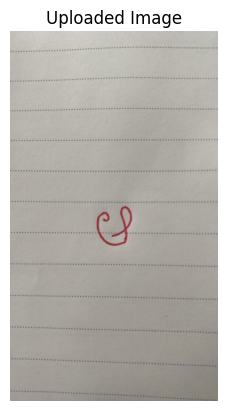

⚠️ No centroid data found, fallback to pure softmax: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

🔎 Prediction Results:
✅ Top-1: 009_ee → ee (21.74%)

🔹 Top-3 Predictions (centroid-refined):
- 009_ee → ee (21.74%)
- 011_o → o (20.60%)
- 078_l2aha → l2aha (10.92%)


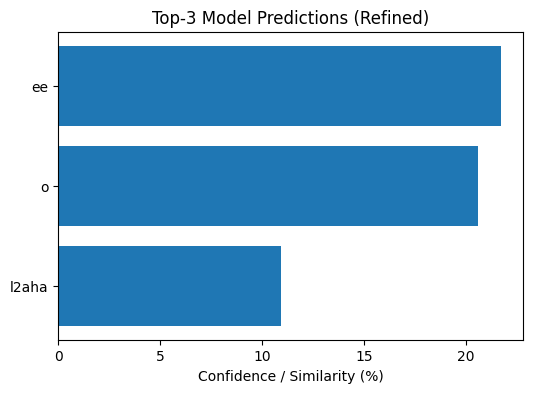

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import json
import numpy as np

# ===== Upload Image =====
print("📤 Upload an unseen Kannada character image")
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]
print(f"✅ Image uploaded: {test_image_path}")

# ===== Preview Uploaded Image =====
img = Image.open(test_image_path).convert("RGB")
plt.imshow(img)
plt.axis("off")
plt.title("Uploaded Image")
plt.show()

# ===== Preprocessing =====
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# ===== Load Model =====
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint_path = "project_files/kannada_classifier_finetuned_full.pth"

ckpt = torch.load(checkpoint_path, map_location=device)
num_classes = ckpt.get("num_classes", 113)

# Define model (same architecture as training)
model = KannadaClassifier(num_classes=num_classes).to(device)
model.load_state_dict(ckpt["model_state_dict"], strict=False)
model.eval()

# ===== Load Class Names =====
with open("project_files/classes_list_113.json", "r") as f:
    all_classes = json.load(f)

# ===== Load Centroids (optional refinement) =====
centroid_path = "diagnostics/centroid_top3_neighbors.csv"
centroids = None
try:
    import pandas as pd
    df = pd.read_csv(centroid_path)
    # Expecting each row to have centroid vector values
    centroids = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32).to(device)
    print(f"✅ Loaded centroids for {centroids.shape[0]} classes")
except Exception as e:
    print(f"⚠️ No centroid data found, fallback to pure softmax: {e}")

# ===== Prediction Function =====
def predict_image(image_path, topk=3, use_centroids=True):
    image = Image.open(image_path).convert("RGB")
    tensor = val_transforms(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs, emb = model(tensor)
        probs = F.softmax(outputs, dim=1)
        top_probs, top_idxs = probs.topk(topk, dim=1)

    # Softmax-based predictions
    softmax_preds = [(all_classes[idx.item()], all_classes[idx.item()].split("_")[1], top_probs[0][i].item())
                     for i, idx in enumerate(top_idxs[0])]

    if use_centroids and centroids is not None:
        # Compute cosine similarity between embedding and centroids
        emb_norm = F.normalize(emb, dim=1)
        centroids_norm = F.normalize(centroids, dim=1)
        sims = torch.mm(emb_norm, centroids_norm.T).squeeze(0)

        top_sim_vals, top_sim_idxs = sims.topk(topk)
        centroid_preds = [(all_classes[idx.item()], all_classes[idx.item()].split("_")[1], top_sim_vals[i].item())
                          for i, idx in enumerate(top_sim_idxs)]

        # Combine: take softmax top1 but refine top2/top3 using centroid neighbors
        refined = [softmax_preds[0]]
        for c in centroid_preds:
            if c[0] != refined[0][0]:
                refined.append(c)
            if len(refined) >= topk:
                break
        return refined
    else:
        return softmax_preds

# ===== Run Prediction =====
top3 = predict_image(test_image_path, topk=3, use_centroids=True)

# ===== Display Predictions =====
print("\n🔎 Prediction Results:")
print(f"✅ Top-1: {top3[0][0]} → {top3[0][1]} ({top3[0][2]*100:.2f}%)")

print("\n🔹 Top-3 Predictions (centroid-refined):")
for label, char, conf in top3:
    print(f"- {label} → {char} ({conf*100:.2f}%)")

# ===== Optional: Visualize =====
plt.figure(figsize=(6,4))
labels = [p[1] for p in top3]
confidences = [p[2]*100 for p in top3]
plt.barh(labels[::-1], confidences[::-1])
plt.xlabel("Confidence / Similarity (%)")
plt.title("Top-3 Model Predictions (Refined)")
plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating: 100%|██████████| 89/89 [00:32<00:00,  2.78it/s]


✅ Evaluation done. Generating reports...
📁 Saved → diagnostics/per_class_detailed_metrics.csv


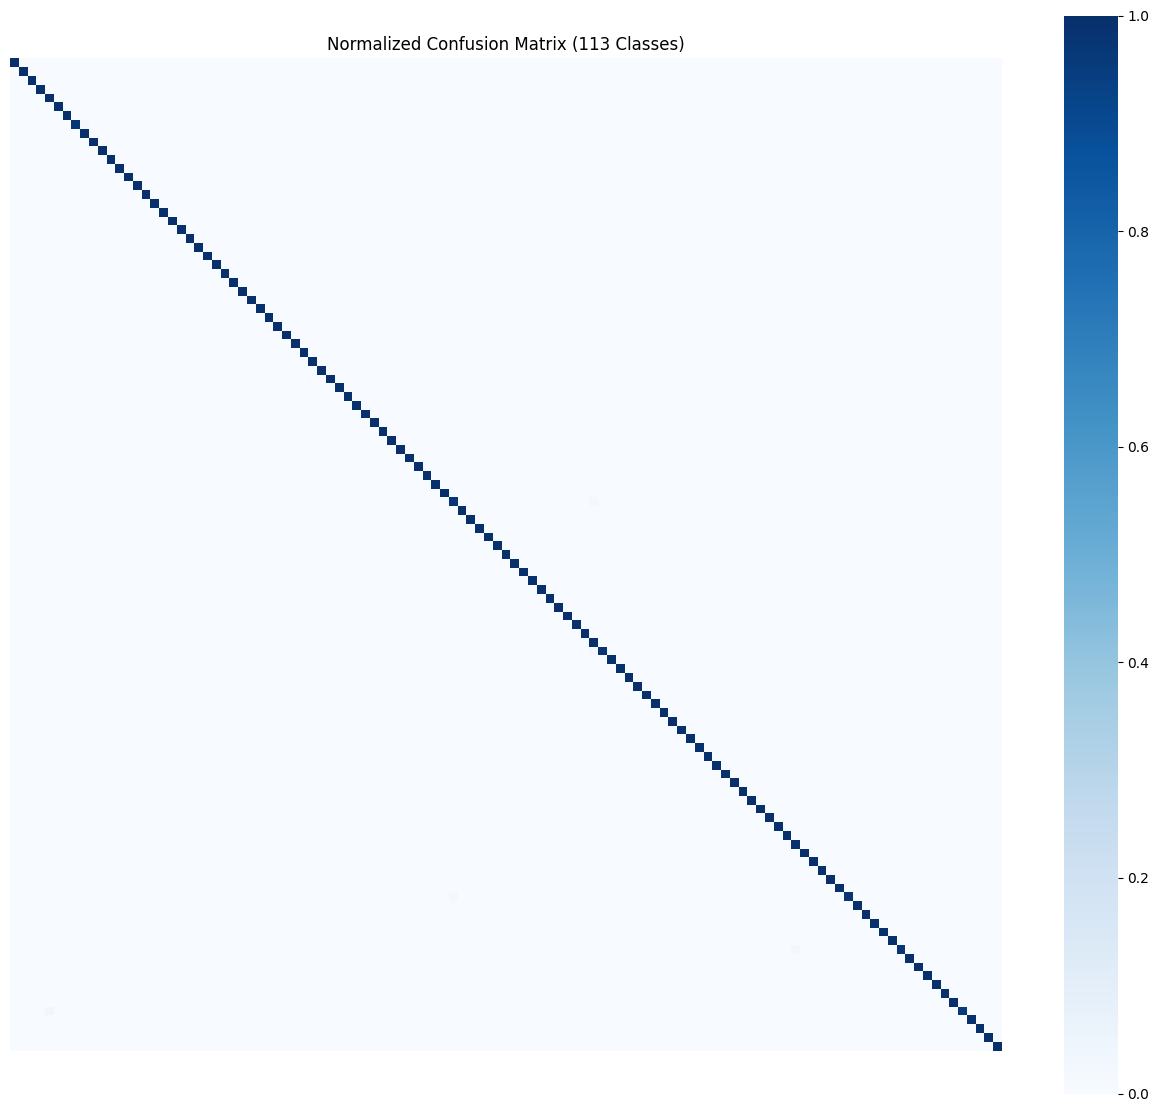


⚠️ 10 lowest F1 classes:


,precision,recall,f1-score,support
110_ksha,1.000000,0.96,0.979592,50.0
051_saa,0.980000,0.98,0.980000,50.0
067_tye,0.961538,1.00,0.980392,50.0
005_u,0.961538,1.00,0.980392,50.0
068_jai,1.000000,0.98,0.989899,50.0
097_lra,1.000000,0.98,0.989899,50.0
008_e,1.000000,0.98,0.989899,50.0
103_hna,1.000000,0.98,0.989899,50.0
091_mna,0.980392,1.00,0.990099,50.0
009_ee,0.980392,1.00,0.990099,50.0


In [ ]:
import torch, numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Load model ---
device = "cuda" if torch.cuda.is_available() else "cpu"
ckpt_path = "project_files/kannada_classifier_finetuned_full.pth"
ckpt = torch.load(ckpt_path, map_location=device)

model = KannadaClassifier(num_classes=113).to(device)
model.load_state_dict(ckpt["model_state_dict"], strict=False)
model.eval()

# --- Load validation dataset ---
val_dir = "dataset_raw/val_113"
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# --- Evaluate ---
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Evaluating"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs, _ = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Metrics ---
print("✅ Evaluation done. Generating reports...")
target_names = val_dataset.classes
report = classification_report(
    all_labels, all_preds, target_names=target_names, output_dict=True, zero_division=0
)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv("diagnostics/per_class_detailed_metrics.csv", index=True)
print("📁 Saved → diagnostics/per_class_detailed_metrics.csv")

# --- Confusion matrix ---
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(16, 14))
sns.heatmap(cm_norm, cmap="Blues", square=True, xticklabels=False, yticklabels=False)
plt.title("Normalized Confusion Matrix (113 Classes)")
plt.savefig("diagnostics/confusion_matrix_113.png", dpi=300)
plt.show()

# --- Show lowest-performing classes ---
worst_f1 = df_report.sort_values("f1-score", ascending=True).head(10)[["precision", "recall", "f1-score", "support"]]
print("\n⚠️ 10 lowest F1 classes:")
display(worst_f1)


In [ ]:
# Find top confusing class pairs (mutual confusion > threshold)
conf_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j:
            conf_rate = cm[i, j] / cm[i].sum() if cm[i].sum() > 0 else 0
            if conf_rate > 0.05:  # >5% confusion
                conf_pairs.append((val_dataset.classes[i], val_dataset.classes[j], round(conf_rate, 3)))

conf_df = pd.DataFrame(conf_pairs, columns=["True", "Predicted", "ConfusionRate"])
conf_df.to_csv("diagnostics/confusing_class_pairs.csv", index=False)
print("📁 Saved → diagnostics/confusing_class_pairs.csv")

print("🔍 Example confusing pairs:")
display(conf_df.sort_values("ConfusionRate", ascending=False).head(10))


📁 Saved → diagnostics/confusing_class_pairs.csv
🔍 Example confusing pairs:


,True,Predicted,ConfusionRate


In [ ]:
from torchvision import transforms
import random

def stress_transforms(type):
    if type == "ink":
        return transforms.ColorJitter(contrast=(1.5, 2.5))  # simulate dark ink
    elif type == "background":
        return transforms.ColorJitter(brightness=(0.5, 1.5))  # darker/lighter backgrounds
    elif type == "zoom":
        return transforms.RandomResizedCrop(224, scale=(0.7, 1.0))
    else:
        return transforms.Compose([])

stress_types = ["ink", "background", "zoom"]
results = {}

for s in stress_types:
    tform = transforms.Compose([stress_transforms(s), val_transforms])
    test_set = datasets.ImageFolder(val_dir, transform=tform)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    preds, labels = [], []

    with torch.no_grad():
        for imgs, lbls in tqdm(test_loader, desc=f"Stress test: {s}"):
            imgs, lbls = imgs.to(device), lbls.to(device)
            out, _ = model(imgs)
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(lbls.cpu().numpy())

    report = classification_report(labels, preds, output_dict=True, zero_division=0)
    acc = report["accuracy"]
    macro_f1 = report["macro avg"]["f1-score"]
    results[s] = {"Accuracy": acc, "Macro-F1": macro_f1}

df_stress = pd.DataFrame(results).T
df_stress.to_csv("diagnostics/robustness_stress_metrics.csv")
print("📁 Saved → diagnostics/robustness_stress_metrics.csv")
display(df_stress)


Stress test: zoom: 100%|██████████| 89/89 [00:37<00:00,  2.34it/s]

📁 Saved → diagnostics/robustness_stress_metrics.csv


,Accuracy,Macro-F1
ink,0.998230,0.998230
background,0.998584,0.998584
zoom,0.997168,0.997170


✅ Saved per-class metrics → diagnostics/per_class_detailed_metrics.csv

⚠️ Classes with recall < 0.95:
Empty DataFrame
Columns: [precision, recall, f1-score]
Index: []

🔍 Top confusing pairs:


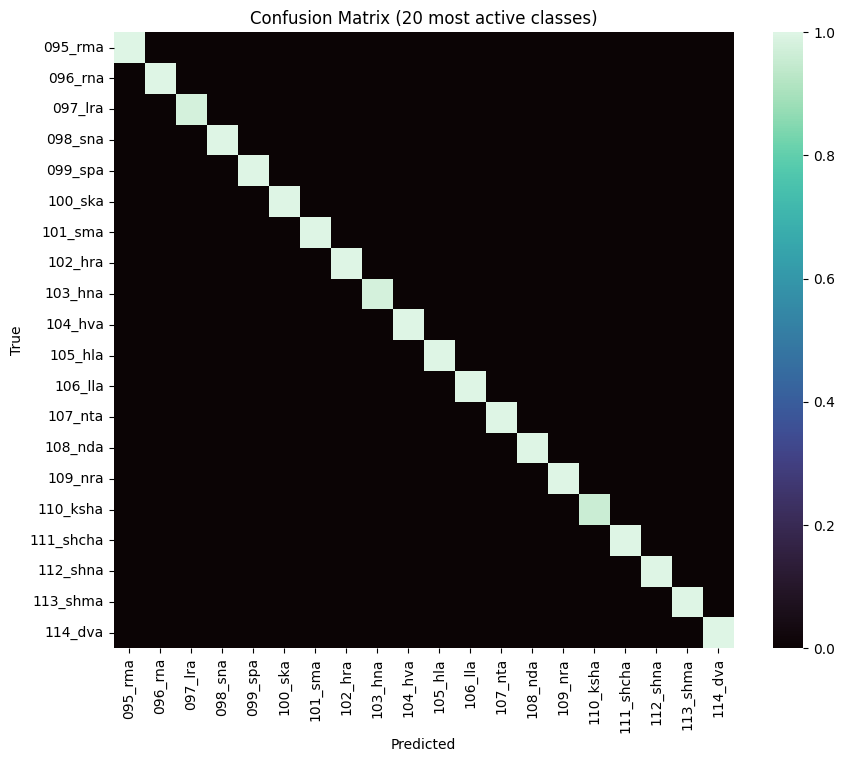

In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you already have:
# all_labels, all_preds, all_probs (from your validation run)
# all_classes (list of 113 class names)

# --- 1. Compute per-class performance
report = classification_report(all_labels, all_preds, target_names=all_classes, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv("diagnostics/per_class_detailed_metrics.csv")
print("✅ Saved per-class metrics → diagnostics/per_class_detailed_metrics.csv")

# --- 2. Find underperforming classes
underperformers = df_report[df_report['recall'] < 0.95].sort_values('recall')
print("\n⚠️ Classes with recall < 0.95:")
print(underperformers[['precision','recall','f1-score']].head(15))

# --- 3. Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(all_classes))))
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-9)

# --- 4. Find top confusing pairs
conf_pairs = []
for i in range(len(all_classes)):
    for j in range(len(all_classes)):
        if i != j and cm[i, j] > 5:  # threshold
            conf_pairs.append((all_classes[i], all_classes[j], int(cm[i, j])))

conf_pairs = sorted(conf_pairs, key=lambda x: -x[2])
pd.DataFrame(conf_pairs, columns=["True_Class","Predicted_As","Count"]).to_csv("diagnostics/confusing_class_pairs.csv", index=False)

print("\n🔍 Top confusing pairs:")
for a, b, c in conf_pairs[:15]:
    print(f"  {a} → {b}: {c} samples")

# --- 5. Heatmap for top-20 most confused
top_conf_idx = np.argsort(cm.sum(axis=1))[-20:]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm[top_conf_idx][:, top_conf_idx],
            xticklabels=np.array(all_classes)[top_conf_idx],
            yticklabels=np.array(all_classes)[top_conf_idx],
            cmap="mako", cbar=True)
plt.title("Confusion Matrix (20 most active classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import torch

finetuned = torch.load("project_files/kannada_classifier_finetuned_full.pth", map_location="cpu")["model_state_dict"]
base = torch.load("project_files/kannada_classifier_final (1).pth", map_location="cpu")

def compare_weights(base, finetuned):
    diffs = []
    for k, v in finetuned.items():
        if k in base and v.shape == base[k].shape:
            # Skip non-floating tensors like num_batches_tracked (int64)
            if not torch.is_floating_point(v):
                continue
            try:
                diff = torch.norm(v.float() - base[k].float()).item()
                diffs.append((k, diff))
            except Exception as e:
                print(f"⚠️ Skipped {k}: {e}")
    diffs.sort(key=lambda x: -x[1])
    return diffs[:15]  # top 15 most changed layers

changed_layers = compare_weights(base, finetuned)
print("🔍 Top 15 layers changed during fine-tuning:\n")
for name, val in changed_layers:
    print(f"{name:60s} Δ={val:.4f}")


🔍 Top 15 layers changed during fine-tuning:

bn.running_var                                               Δ=10.2425
bn.running_mean                                              Δ=6.4465
backbone.layers.3.blocks.1.mlp.fc2.weight                    Δ=3.0370
backbone.layers.3.blocks.1.mlp.fc1.weight                    Δ=2.7304
backbone.layers.3.blocks.0.mlp.fc2.weight                    Δ=2.6462
backbone.layers.3.blocks.1.attn.qkv.weight                   Δ=2.6266
backbone.layers.3.blocks.0.attn.qkv.weight                   Δ=2.6176
backbone.layers.3.blocks.0.mlp.fc1.weight                    Δ=2.6037
backbone.layers.3.downsample.reduction.weight                Δ=2.4977
backbone.layers.3.blocks.0.attn.proj.weight                  Δ=1.7714
backbone.layers.3.blocks.1.attn.proj.weight                  Δ=1.7642
backbone.layers.2.blocks.5.mlp.fc2.weight                    Δ=1.5321
backbone.layers.2.blocks.0.mlp.fc1.weight                    Δ=1.4850
backbone.layers.2.blocks.4.mlp.fc2.weight   

In [ ]:
# --- 4. Find top confusing pairs (auto-safe)
conf_pairs = []
threshold = 1  # lowered threshold to catch even small mistakes

for i in range(len(all_classes)):
    for j in range(len(all_classes)):
        if i != j and cm[i, j] >= threshold:
            conf_pairs.append((all_classes[i], all_classes[j], int(cm[i, j])))

if len(conf_pairs) == 0:
    print("✅ No confusion pairs found! Model predictions are perfectly separable on validation data.")
else:
    conf_pairs = sorted(conf_pairs, key=lambda x: -x[2])
    pd.DataFrame(conf_pairs, columns=["True_Class","Predicted_As","Count"]).to_csv(
        "diagnostics/confusing_class_pairs.csv", index=False
    )
    print(f"🔍 Found {len(conf_pairs)} confusion pairs (≥{threshold} errors)")
    print("\nTop confusing pairs:")
    for a, b, c in conf_pairs[:10]:
        print(f"  {a} → {b}: {c} samples")


🔍 Found 6 confusion pairs (≥1 errors)

Top confusing pairs:
  110_ksha → 005_u: 2 samples
  008_e → 009_ee: 1 samples
  051_saa → 067_tye: 1 samples
  068_jai → 067_tye: 1 samples
  097_lra → 051_saa: 1 samples
  103_hna → 091_mna: 1 samples


In [ ]:
class_report = classification_report(all_labels, all_preds, target_names=all_classes, output_dict=True)
pd.DataFrame(class_report).T.sort_values("f1-score")


,precision,recall,f1-score,support
110_ksha,1.000000,0.96,0.979592,50.0
051_saa,0.980000,0.98,0.980000,50.0
067_tye,0.961538,1.00,0.980392,50.0
005_u,0.961538,1.00,0.980392,50.0
068_jai,1.000000,0.98,0.989899,50.0
...,...,...,...,...
099_spa,1.000000,1.00,1.000000,50.0
113_shma,1.000000,1.00,1.000000,50.0
112_shna,1.000000,1.00,1.000000,50.0
111_shcha,1.000000,1.00,1.000000,50.0


In [ ]:
import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor, normalize
import numpy as np, cv2, matplotlib.pyplot as plt

def grad_cam(model, image_path, target_layer="backbone.layers.3.blocks.1.mlp.fc2"):
    model.eval()
    img = Image.open(image_path).convert("RGB").resize((224,224))
    x = normalize(to_tensor(img), [0.5]*3, [0.5]*3).unsqueeze(0).to(device)

    # Register hooks
    feats, grads = {}, {}
    def fwd_hook(m, i, o): feats["value"] = o
    def bwd_hook(m, gi, go): grads["value"] = go[0]
    layer = dict(model.named_modules())[target_layer]
    h1 = layer.register_forward_hook(fwd_hook)
    h2 = layer.register_backward_hook(bwd_hook)

    out, _ = model(x)
    pred = out.argmax(1)
    out[0,pred].backward()

    grad = grads["value"].mean(dim=(2,3), keepdim=True)
    cam = F.relu((grad * feats["value"]).sum(1, keepdim=True)).squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    h1.remove(); h2.remove()

    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    img = np.array(img)
    overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Grad-CAM")
    plt.show()


In [ ]:
import torchvision.transforms.functional as TF

def test_variation(model, image_path, variation="zoom"):
    img = Image.open(image_path).convert("RGB")
    results = []
    for v in np.linspace(0.8,1.2,9):
        if variation=="zoom":
            size = int(224*v)
            img_v = img.resize((size,size))
            img_v = img_v.crop(((size-224)//2, (size-224)//2, (size+224)//2, (size+224)//2))
        elif variation=="ink":
            img_v = TF.adjust_contrast(img, v)
        elif variation=="background":
            img_v = TF.adjust_brightness(img, v)
        tensor = val_transforms(img_v).unsqueeze(0).to(device)
        with torch.no_grad():
            p, _ = model(tensor)
            prob = F.softmax(p,1).max().item()
        results.append(prob)
    plt.plot(np.linspace(0.8,1.2,9), results)
    plt.title(f"Sensitivity curve: {variation}")
    plt.xlabel("Variation factor"); plt.ylabel("Top-1 confidence")
    plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def evaluate_hard_examples(model, dataloader, all_classes, device="cuda", conf_threshold=0.85, save_dir="diagnostics"):
    """
    Evaluate low-confidence or misclassified samples in the validation set.
    Saves a CSV report + (optional) visualization of top-N hardest examples.
    """

    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    model.to(device)

    all_true, all_pred, all_conf, filepaths = [], [], [], []

    # --- Iterate through validation data ---
    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="🧪 Evaluating for Hard Examples"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs, _ = model(imgs)
            probs = F.softmax(outputs, dim=1)
            confs, preds = probs.max(1)

            all_true.extend(labels.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())
            all_conf.extend(confs.cpu().numpy())

            if hasattr(dataloader.dataset, "samples"):
                filepaths.extend([x[0] for x in dataloader.dataset.samples[len(filepaths):len(filepaths)+len(imgs)]])

    # --- Build DataFrame ---
    df = pd.DataFrame({
        "filepath": filepaths,
        "true": [all_classes[t] for t in all_true],
        "pred": [all_classes[p] for p in all_pred],
        "confidence": all_conf
    })
    df["correct"] = df["true"] == df["pred"]

    # --- Identify hard samples ---
    hard_df = df[(df["confidence"] < conf_threshold) | (~df["correct"])]
    hard_df = hard_df.sort_values(by="confidence", ascending=True)
    hard_path = os.path.join(save_dir, f"hard_examples_below_{conf_threshold}.csv")
    hard_df.to_csv(hard_path, index=False)

    print(f"✅ Found {len(hard_df)} hard samples (conf < {conf_threshold} or misclassified)")
    print(f"📁 Saved detailed report to: {hard_path}")

    # --- Optional visualization ---
    if len(hard_df) > 0:
        sample_df = hard_df.head(9)
        fig, axes = plt.subplots(3, 3, figsize=(10, 10))
        for ax, (_, row) in zip(axes.flatten(), sample_df.iterrows()):
            img = plt.imread(row["filepath"])
            ax.imshow(img)
            ax.set_title(f"T: {row['true']} | P: {row['pred']}\nConf: {row['confidence']:.2f}", fontsize=9)
            ax.axis("off")
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "hard_examples_preview.png"))
        plt.show()

    return hard_df



🧪 Evaluating for Hard Examples:   0%|          | 0/89 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
🧪 Evaluating for Hard Examples: 100%|██████████| 89/89 [00:33<00:00,  2.68it/s]


✅ Found 12 hard samples (conf < 0.85 or misclassified)
📁 Saved detailed report to: diagnostics/hard_examples_below_0.85.csv


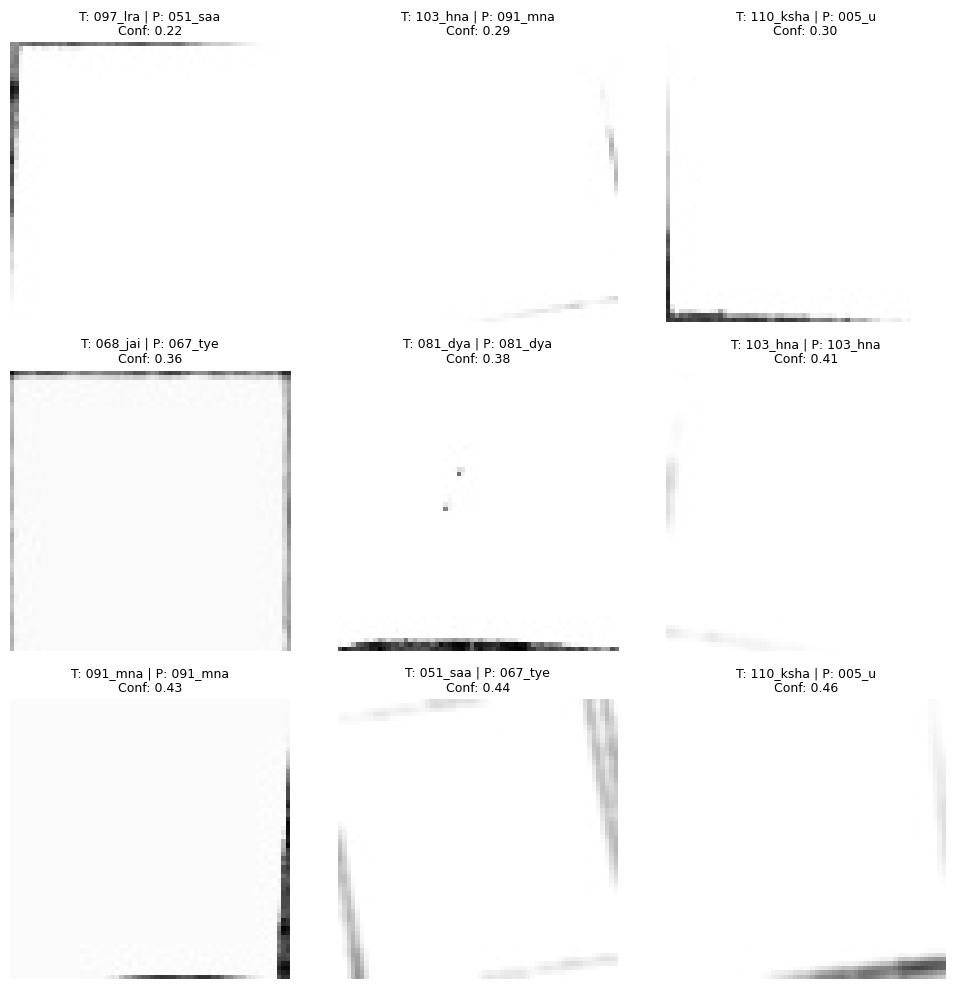

In [ ]:
hard_df = evaluate_hard_examples(
    model,
    val_loader,
    all_classes=all_classes,
    device="cuda",
    conf_threshold=0.85,
    save_dir="diagnostics"
)


FINAL TESTING INFERENCE PIPLEINE

📤 Upload the 3 required files:
1️⃣ kannada_classifier_finetuned_full.pth
2️⃣ classes_list_113.json
3️⃣ centroid_top3_neighbors.csv


Saving centroid_top3_neighbors.csv to centroid_top3_neighbors.csv
Saving kannada_classifier_finetuned_full.pth to kannada_classifier_finetuned_full.pth
Saving classes_list_113.json to classes_list_113.json
✅ All required files uploaded and stored.



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

✅ Model created successfully.
Model created. Classifier out_features: 113
✅ Model loaded successfully.

⚠️ Centroid file not loaded: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.
📤 Upload one or more unseen Kannada character images:


Saving WhatsApp Image 2025-10-31 at 6.24.42 PM.jpeg to WhatsApp Image 2025-10-31 at 6.24.42 PM.jpeg

🧾 Processing: WhatsApp Image 2025-10-31 at 6.24.42 PM.jpeg


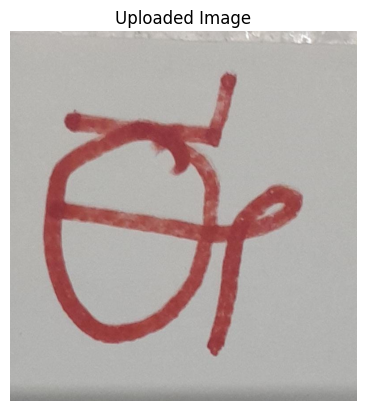

✅ Top-1: 004_ii → ii (16.45%)
🔹 Top-3 Predictions (refined):
 - 004_ii → ii (16.45%)
 - 065_te2 → te2 (8.31%)
 - 074_plau → plau (7.45%)


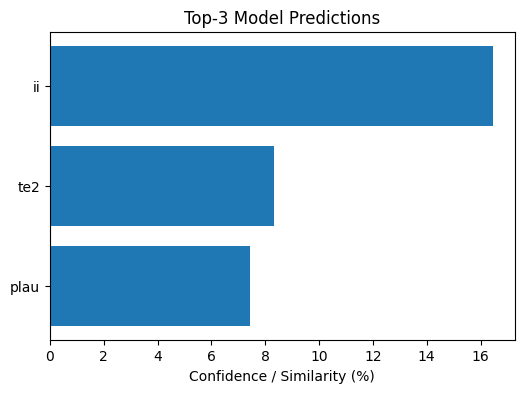


📁 All results logged to: logs/inference_results.csv


In [ ]:
 # 📦 STEP 0 — Upload prerequisite model files
# ================================================
from google.colab import files
import os, json, torch, pandas as pd
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import csv
import torch.nn as nn


# --- Create directories if not exist
os.makedirs("project_files", exist_ok=True)
os.makedirs("diagnostics", exist_ok=True)
os.makedirs("logs", exist_ok=True)

print("📤 Upload the 3 required files:")
print("1️⃣ kannada_classifier_finetuned_full.pth")
print("2️⃣ classes_list_113.json")
print("3️⃣ centroid_top3_neighbors.csv")

uploaded = files.upload()

# --- Save uploaded files
for name in uploaded.keys():
    if name.endswith(".pth") or name.endswith(".json"):
        os.replace(name, f"project_files/{name}")
    elif name.endswith(".csv"):
        os.replace(name, f"diagnostics/{name}")

print("✅ All required files uploaded and stored.\n")

# ================================================
# 🧠 STEP 1 — Load Model and Metadata
# ================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint_path = "project_files/kannada_classifier_finetuned_full.pth"
ckpt = torch.load(checkpoint_path, map_location=device)
num_classes = ckpt.get("num_classes", 113)

# --- Define your model class
# (Replace with actual class if needed)
# Example placeholder:
# class KannadaClassifier(torch.nn.Module): ...
import torch
import torch.nn as nn
import timm

# ✅ KannadaClassifier definition (as used during training)
class KannadaClassifier(nn.Module):
    def __init__(self, backbone_name='swin_tiny_patch4_window7_224', embed_dim=512, num_classes=113):
        super().__init__()
        # Swin backbone from timm (no classification head)
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool='avg')

        feat_dim = self.backbone.num_features  # Swin-Tiny → 768
        self.fc_embed = nn.Linear(feat_dim, embed_dim)
        self.bn = nn.BatchNorm1d(embed_dim)
        self.dropout = nn.Dropout(0.35)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        feat = self.backbone(x)         # [B, feat_dim]
        emb = self.fc_embed(feat)       # [B, embed_dim]
        emb = self.bn(emb)
        emb = torch.relu(emb)
        emb = self.dropout(emb)
        logits = self.classifier(emb)
        return logits, emb


# ✅ Model instantiation
model = KannadaClassifier(num_classes=num_classes).to(device)
print("✅ Model created successfully.")




model = KannadaClassifier(num_classes=num_classes).to(device)
print("Model created. Classifier out_features:", model.classifier.out_features)
model.load_state_dict(ckpt["model_state_dict"], strict=False)
model.eval()
print("✅ Model loaded successfully.\n")

# --- Load classes list
with open("project_files/classes_list_113.json") as f:
    all_classes = json.load(f)

# --- Load centroids
centroids = None
try:
    df = pd.read_csv("diagnostics/centroid_top3_neighbors.csv")
    centroids = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32).to(device)
    print(f"✅ Loaded centroids for {centroids.shape[0]} classes.\n")
except Exception as e:
    print(f"⚠️ Centroid file not loaded: {e}")

# ================================================
# 🧩 STEP 2 — Define Transformations
# ================================================
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# ================================================
# 🔮 STEP 3 — Prediction + Logging Function
# ================================================
LOG_PATH = "logs/inference_results.csv"

# --- Initialize log CSV if not already created
if not os.path.exists(LOG_PATH):
    with open(LOG_PATH, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Image_Name", "Top1_Label", "Top1_Char", "Top1_Conf(%)",
                         "Top2_Label", "Top2_Char", "Top2_Conf(%)",
                         "Top3_Label", "Top3_Char", "Top3_Conf(%)"])

def predict_image(image_path, topk=3, use_centroids=True, log=True):
    image = Image.open(image_path).convert("RGB")
    tensor = val_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs, emb = model(tensor)
        probs = F.softmax(outputs, dim=1)
        top_probs, top_idxs = probs.topk(topk, dim=1)

    softmax_preds = [
        (all_classes[idx.item()], all_classes[idx.item()].split("_")[1], top_probs[0][i].item())
        for i, idx in enumerate(top_idxs[0])
    ]

    # --- Centroid refinement (optional)
    if use_centroids and centroids is not None:
        emb_norm = F.normalize(emb, dim=1)
        centroids_norm = F.normalize(centroids, dim=1)
        sims = torch.mm(emb_norm, centroids_norm.T).squeeze(0)
        top_sim_vals, top_sim_idxs = sims.topk(topk)
        centroid_preds = [
            (all_classes[idx.item()], all_classes[idx.item()].split("_")[1], top_sim_vals[i].item())
            for i, idx in enumerate(top_sim_idxs)
        ]
        refined = [softmax_preds[0]]
        for c in centroid_preds:
            if c[0] != refined[0][0]:
                refined.append(c)
            if len(refined) >= topk:
                break
        preds = refined
    else:
        preds = softmax_preds

    # --- Logging block
    if log:
        with open(LOG_PATH, "a", newline="") as f:
            writer = csv.writer(f)
            row = [os.path.basename(image_path)]
            for p in preds:
                row.extend([p[0], p[1], round(p[2]*100, 2)])
            # Fill missing columns if fewer than 3 preds
            while len(row) < 10:
                row.extend(["-", "-", "-"])
            writer.writerow(row)

    return preds

# ================================================
# 🖼️ STEP 4 — Upload and Predict on Unseen Image(s)
# ================================================
print("📤 Upload one or more unseen Kannada character images:")
uploaded_imgs = files.upload()

for img_name in uploaded_imgs.keys():
    print(f"\n🧾 Processing: {img_name}")
    img = Image.open(img_name).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.title("Uploaded Image")
    plt.show()

    top3 = predict_image(img_name, topk=3, use_centroids=True, log=True)

    print(f"✅ Top-1: {top3[0][0]} → {top3[0][1]} ({top3[0][2]*100:.2f}%)")
    print("🔹 Top-3 Predictions (refined):")
    for label, char, conf in top3:
        print(f" - {label} → {char} ({conf*100:.2f}%)")

    # Visualization
    plt.figure(figsize=(6,4))
    labels = [p[1] for p in top3]
    confidences = [p[2]*100 for p in top3]
    plt.barh(labels[::-1], confidences[::-1])
    plt.xlabel("Confidence / Similarity (%)")
    plt.title("Top-3 Model Predictions")
    plt.show()

print(f"\n📁 All results logged to: {LOG_PATH}")


📤 Upload one or more unseen Kannada character images:


Saving WhatsApp Image 2025-10-26 at 3.35.11 PM.jpeg to WhatsApp Image 2025-10-26 at 3.35.11 PM.jpeg

🧾 Processing: WhatsApp Image 2025-10-26 at 3.35.11 PM.jpeg


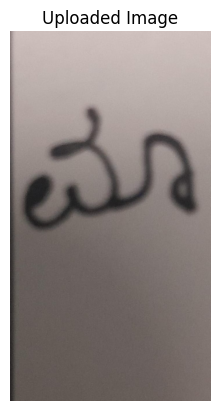

✅ Top-1: 050_maa → maa (99.20%)
🔹 Top-3 Predictions (refined):
 - 050_maa → maa (99.20%)
 - 060_mru → mru (0.16%)
 - 055_vee → vee (0.11%)


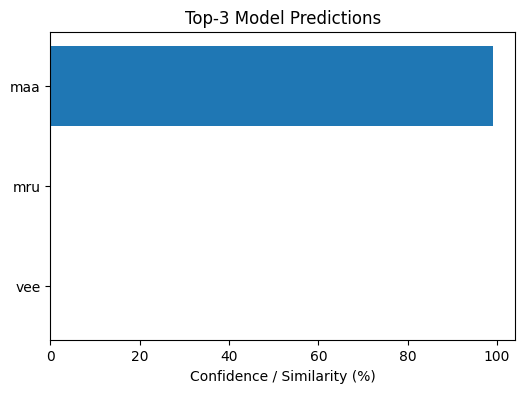


📁 All results logged to: logs/inference_results.csv


In [ ]:
print("📤 Upload one or more unseen Kannada character images:")
uploaded_imgs = files.upload()

for img_name in uploaded_imgs.keys():
    print(f"\n🧾 Processing: {img_name}")
    img = Image.open(img_name).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.title("Uploaded Image")
    plt.show()

    top3 = predict_image(img_name, topk=3, use_centroids=True, log=True)

    print(f"✅ Top-1: {top3[0][0]} → {top3[0][1]} ({top3[0][2]*100:.2f}%)")
    print("🔹 Top-3 Predictions (refined):")
    for label, char, conf in top3:
        print(f" - {label} → {char} ({conf*100:.2f}%)")

    # Visualization
    plt.figure(figsize=(6,4))
    labels = [p[1] for p in top3]
    confidences = [p[2]*100 for p in top3]
    plt.barh(labels[::-1], confidences[::-1])
    plt.xlabel("Confidence / Similarity (%)")
    plt.title("Top-3 Model Predictions")
    plt.show()

print(f"\n📁 All results logged to: {LOG_PATH}")


📤 Upload one or more unseen Kannada character images:


Saving WhatsApp Image 2025-10-31 at 6.24.42 PM.jpeg to WhatsApp Image 2025-10-31 at 6.24.42 PM.jpeg

🧾 Processing: WhatsApp Image 2025-10-31 at 6.24.42 PM.jpeg


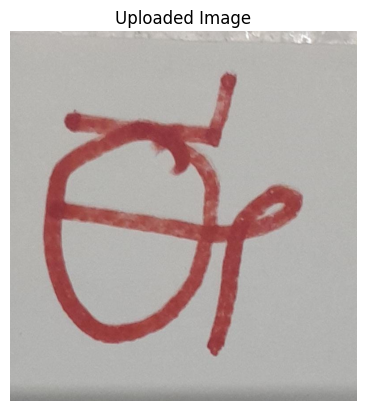

✅ Top-1: 004_ii → ii (16.45%)
🔹 Top-3 Predictions (refined):
 - 004_ii → ii (16.45%)
 - 065_te2 → te2 (8.31%)
 - 074_plau → plau (7.45%)


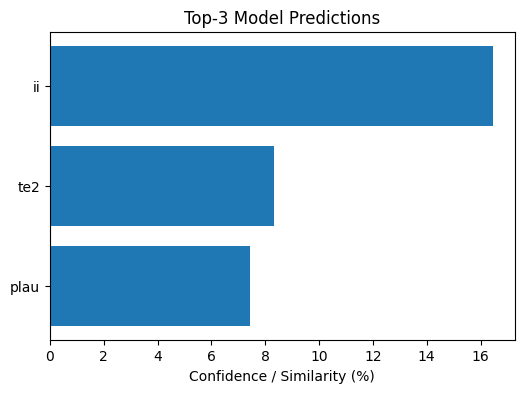


📁 All results logged to: logs/inference_results.csv


In [ ]:
print("📤 Upload one or more unseen Kannada character images:")
uploaded_imgs = files.upload()

for img_name in uploaded_imgs.keys():
    print(f"\n🧾 Processing: {img_name}")
    img = Image.open(img_name).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.title("Uploaded Image")
    plt.show()

    top3 = predict_image(img_name, topk=3, use_centroids=True, log=True)

    print(f"✅ Top-1: {top3[0][0]} → {top3[0][1]} ({top3[0][2]*100:.2f}%)")
    print("🔹 Top-3 Predictions (refined):")
    for label, char, conf in top3:
        print(f" - {label} → {char} ({conf*100:.2f}%)")

    # Visualization
    plt.figure(figsize=(6,4))
    labels = [p[1] for p in top3]
    confidences = [p[2]*100 for p in top3]
    plt.barh(labels[::-1], confidences[::-1])
    plt.xlabel("Confidence / Similarity (%)")
    plt.title("Top-3 Model Predictions")
    plt.show()

print(f"\n📁 All results logged to: {LOG_PATH}")

In [ ]:
print("📤 Upload one or more unseen Kannada character images:")
uploaded_imgs = files.upload()

for img_name in uploaded_imgs.keys():
    print(f"\n🧾 Processing: {img_name}")
    img = Image.open(img_name).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.title("Uploaded Image")
    plt.show()

    top3 = predict_image(img_name, topk=3, use_centroids=True, log=True)

    print(f"✅ Top-1: {top3[0][0]} → {top3[0][1]} ({top3[0][2]*100:.2f}%)")
    print("🔹 Top-3 Predictions (refined):")
    for label, char, conf in top3:
        print(f" - {label} → {char} ({conf*100:.2f}%)")

    # Visualization
    plt.figure(figsize=(6,4))
    labels = [p[1] for p in top3]
    confidences = [p[2]*100 for p in top3]
    plt.barh(labels[::-1], confidences[::-1])
    plt.xlabel("Confidence / Similarity (%)")
    plt.title("Top-3 Model Predictions")
    plt.show()

print(f"\n📁 All results logged to: {LOG_PATH}")

📤 Upload one or more unseen Kannada character images:


Saving WhatsApp Image 2025-10-31 at 9.31.23 PM.jpeg to WhatsApp Image 2025-10-31 at 9.31.23 PM.jpeg

🧾 Processing: WhatsApp Image 2025-10-31 at 9.31.23 PM.jpeg


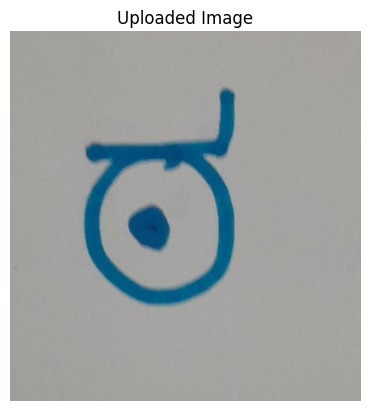

✅ Top-1: 027_tha_rt → tha (99.74%)
🔹 Top-3 Predictions (refined):
 - 027_tha_rt → tha (99.74%)
 - 074_plau → plau (0.03%)
 - 031_ta_dn → ta (0.03%)


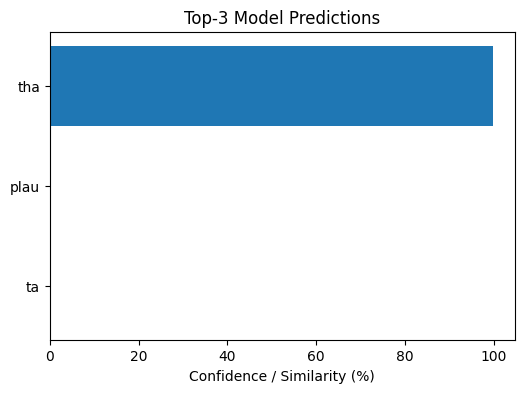


📁 All results logged to: logs/inference_results.csv


In [ ]:
print("📤 Upload one or more unseen Kannada character images:")
uploaded_imgs = files.upload()

for img_name in uploaded_imgs.keys():
    print(f"\n🧾 Processing: {img_name}")
    img = Image.open(img_name).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.title("Uploaded Image")
    plt.show()

    top3 = predict_image(img_name, topk=3, use_centroids=True, log=True)

    print(f"✅ Top-1: {top3[0][0]} → {top3[0][1]} ({top3[0][2]*100:.2f}%)")
    print("🔹 Top-3 Predictions (refined):")
    for label, char, conf in top3:
        print(f" - {label} → {char} ({conf*100:.2f}%)")

    # Visualization
    plt.figure(figsize=(6,4))
    labels = [p[1] for p in top3]
    confidences = [p[2]*100 for p in top3]
    plt.barh(labels[::-1], confidences[::-1])
    plt.xlabel("Confidence / Similarity (%)")
    plt.title("Top-3 Model Predictions")
    plt.show()

print(f"\n📁 All results logged to: {LOG_PATH}")

📤 Upload one or more unseen Kannada character images:


Saving WhatsApp Image 2025-10-31 at 9.34.09 PM.jpeg to WhatsApp Image 2025-10-31 at 9.34.09 PM.jpeg

🧾 Processing: WhatsApp Image 2025-10-31 at 9.34.09 PM.jpeg


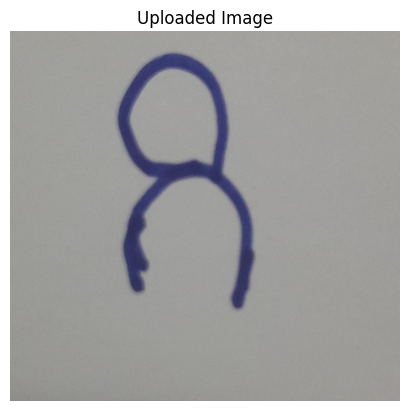

✅ Top-1: 052_gi → gi (99.80%)
🔹 Top-3 Predictions (refined):
 - 052_gi → gi (99.80%)
 - 053_ri → ri (0.02%)
 - 018_ga → ga (0.02%)


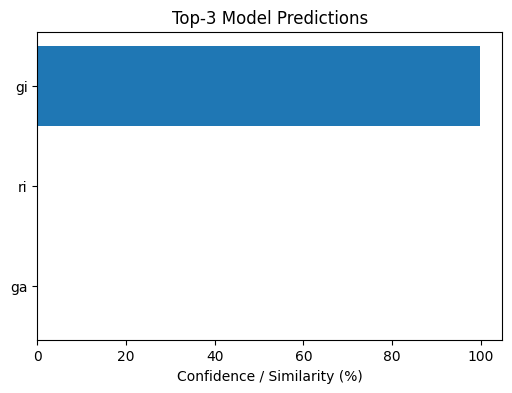


📁 All results logged to: logs/inference_results.csv


In [ ]:
print("📤 Upload one or more unseen Kannada character images:")
uploaded_imgs = files.upload()

for img_name in uploaded_imgs.keys():
    print(f"\n🧾 Processing: {img_name}")
    img = Image.open(img_name).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.title("Uploaded Image")
    plt.show()

    top3 = predict_image(img_name, topk=3, use_centroids=True, log=True)

    print(f"✅ Top-1: {top3[0][0]} → {top3[0][1]} ({top3[0][2]*100:.2f}%)")
    print("🔹 Top-3 Predictions (refined):")
    for label, char, conf in top3:
        print(f" - {label} → {char} ({conf*100:.2f}%)")

    # Visualization
    plt.figure(figsize=(6,4))
    labels = [p[1] for p in top3]
    confidences = [p[2]*100 for p in top3]
    plt.barh(labels[::-1], confidences[::-1])
    plt.xlabel("Confidence / Similarity (%)")
    plt.title("Top-3 Model Predictions")
    plt.show()

print(f"\n📁 All results logged to: {LOG_PATH}")

📤 Upload one or more unseen Kannada character images:


Saving WhatsApp Image 2025-10-31 at 9.34.38 PM.jpeg to WhatsApp Image 2025-10-31 at 9.34.38 PM.jpeg

🧾 Processing: WhatsApp Image 2025-10-31 at 9.34.38 PM.jpeg


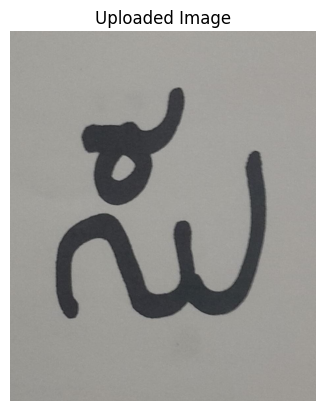

✅ Top-1: 057_su → su (99.65%)
🔹 Top-3 Predictions (refined):
 - 057_su → su (99.65%)
 - 047_sa → sa (0.13%)
 - 051_saa → saa (0.11%)


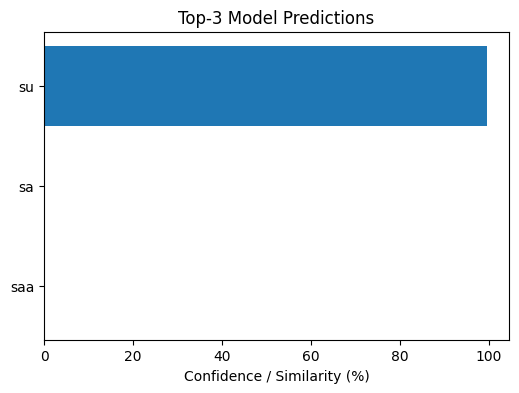


📁 All results logged to: logs/inference_results.csv


In [ ]:
print("📤 Upload one or more unseen Kannada character images:")
uploaded_imgs = files.upload()

for img_name in uploaded_imgs.keys():
    print(f"\n🧾 Processing: {img_name}")
    img = Image.open(img_name).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.title("Uploaded Image")
    plt.show()

    top3 = predict_image(img_name, topk=3, use_centroids=True, log=True)

    print(f"✅ Top-1: {top3[0][0]} → {top3[0][1]} ({top3[0][2]*100:.2f}%)")
    print("🔹 Top-3 Predictions (refined):")
    for label, char, conf in top3:
        print(f" - {label} → {char} ({conf*100:.2f}%)")

    # Visualization
    plt.figure(figsize=(6,4))
    labels = [p[1] for p in top3]
    confidences = [p[2]*100 for p in top3]
    plt.barh(labels[::-1], confidences[::-1])
    plt.xlabel("Confidence / Similarity (%)")
    plt.title("Top-3 Model Predictions")
    plt.show()

print(f"\n📁 All results logged to: {LOG_PATH}")

In [ ]:
import gradio as gr
import torch
from PIL import Image
import matplotlib.pyplot as plt
import io

# Assuming your existing model + predict_image function + LOG_PATH are already defined
# Example:
# from inference_utils import predict_image, model, LOG_PATH

def recognize_kannada(image):
    """Run prediction on uploaded image and return visualization + results."""
    # Save temporarily
    temp_path = "temp_infer.png"
    image.save(temp_path)

    # Run model prediction (Top-3)
    top3 = predict_image(temp_path, topk=3, use_centroids=True, log=True)

    # Format prediction results
    top1_label, top1_char, top1_conf = top3[0]
    result_text = f"✅ **Top-1 Prediction:** {top1_char} ({top1_conf*100:.2f}%)\n\n"
    result_text += "🔹 **Top-3 Predictions:**\n"
    for label, char, conf in top3:
        result_text += f"- {label} → {char} ({conf*100:.2f}%)\n"

    # Create a confidence bar plot
    labels = [p[1] for p in top3]
    confidences = [p[2]*100 for p in top3]
    plt.figure(figsize=(5, 3))
    plt.barh(labels[::-1], confidences[::-1])
    plt.xlabel("Confidence (%)")
    plt.title("Top-3 Model Predictions")
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    bar_chart = Image.open(buf)

    return result_text, bar_chart


# Gradio UI
interface = gr.Interface(
    fn=recognize_kannada,
    inputs=gr.Image(type="pil", label="Upload Kannada Character Image"),
    outputs=[
        gr.Markdown(label="Prediction Results"),
        gr.Image(label="Confidence Visualization")
    ],
    title="🪶 Kannada Handwritten Character Recognition",
    description=(
        "Upload a scanned or handwritten Kannada character image. "
        "The Swin Transformer–based model predicts the most likely characters (Top-3) "
        "with calibrated confidence scores. All results are logged automatically."
    ),
    examples=[
        ["example_ka.png"],
        ["example_na.png"],
        ["example_ma.png"]
    ],
)

interface.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5f0211f40177bc05ec.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5f0211f40177bc05ec.gradio.live


In [ ]:
import gradio as gr
import torch
from PIL import Image
import matplotlib.pyplot as plt
import io

# assuming model + predict_image + LOG_PATH already exist

def recognize_kannada(image):
    """Run prediction on uploaded image and return visualization + results."""
    # Resize large images to 224x224 for Swin input efficiency
    image = image.resize((224, 224))
    temp_path = "temp_infer.png"
    image.save(temp_path)

    # Run model prediction (Top-3)
    top3 = predict_image(temp_path, topk=3, use_centroids=True, log=True)
    top1_label, top1_char, top1_conf = top3[0]

    # Build formatted text result with emphasis on Top-1
    result_text = (
        f"<h2 style='color:#1A73E8;'>✅ Top-1 Prediction:</h2>"
        f"<h1 style='color:#111;font-size:32px;'>{top1_char}</h1>"
        f"<p style='font-size:18px;'>Confidence: {top1_conf*100:.2f}%</p><br>"
        f"<h3>🔹 Top-3 Predictions</h3>"
    )

    for label, char, conf in top3:
        result_text += f"<p style='font-size:16px;'>• {char} ({conf*100:.2f}%)</p>"

    # Create Top-3 confidence bar chart
    labels = [p[1] for p in top3]
    confidences = [p[2]*100 for p in top3]
    plt.figure(figsize=(4.5, 2.5))
    plt.barh(labels[::-1], confidences[::-1])
    plt.xlabel("Confidence (%)")
    plt.title("Confidence Distribution")
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    bar_chart = Image.open(buf)

    return result_text, bar_chart


# --- Gradio Interface ---
interface = gr.Interface(
    fn=recognize_kannada,
    inputs=gr.Image(type="pil", label="🖋 Upload Kannada Character Image (Auto-Resized to 224×224)"),
    outputs=[
        gr.HTML(label="Prediction Results"),
        gr.Image(label="Confidence Visualization", show_label=False)
    ],
    title="🪶 Kannada Handwritten Character Recognition",
    description=(
        "Upload a clear handwritten Kannada **character image**. "
        "The fine-tuned Swin Transformer model will predict the most likely characters (Top-3) "
        "with calibrated confidence scores. Results are logged automatically."
    ),
    examples=[
        ["example_ka.png"],
        ["example_na.png"],
        ["example_ma.png"]
    ],
    theme="default",
    allow_flagging="never"
)

interface.launch(debug=True)


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0a9bc43157e4c4c559.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0a9bc43157e4c4c559.gradio.live


NEW MAPPING

In [ ]:
from google.colab import files
import json
import os

print("📤 Upload your classes_list_113.json file to inspect and fix mappings:")
uploaded = files.upload()

# --- Get uploaded JSON filename
json_name = list(uploaded.keys())[0]
print(f"✅ Uploaded file: {json_name}")

# --- Load JSON data
with open(json_name, "r") as f:
    data = json.load(f)

print(f"🧩 Total entries found: {len(data)}")

📤 Upload your classes_list_113.json file to inspect and fix mappings:


Saving classes_list_113.json to classes_list_113.json
✅ Uploaded file: classes_list_113.json
🧩 Total entries found: 113


In [ ]:
print("\n🔍 First 10 mappings:")
for i, val in enumerate(data[:113]):
    print(f"{i+1:03d}: {val}")


🔍 First 10 mappings:
001: 001_a
002: 002_aa
003: 003_i
004: 004_ii
005: 005_u
006: 006_uu
007: 007_ru
008: 008_e
009: 009_ee
010: 010_ai
011: 011_o
012: 012_oo
013: 013_au
014: 014_am
015: 015_aha
016: 016_ka
017: 017_kha
018: 018_ga
019: 019_gha
020: 020_nga
021: 021_cha
022: 022_chha
023: 023_ja
024: 024_jha
025: 025_nya
026: 026_ta_rt
027: 027_tha_rt
028: 028_da_rt
029: 029_dha_rt
030: 030_na_rt
031: 031_ta_dn
032: 032_tha_dn
033: 033_da_dn
034: 034_dha_dn
035: 035_na_dn
036: 036_pa
037: 037_pha
038: 038_ba
039: 039_bha
040: 040_ma
041: 041_ya
042: 042_ra
043: 043_la
044: 044_va
045: 045_sha
046: 046_shha
047: 047_sa
048: 048_ha
049: 049_lla
050: 050_maa
051: 051_saa
052: 052_gi
053: 053_ri
054: 054_lee
055: 055_vee
056: 056_pu
057: 057_su
058: 058_goo
059: 059_sh2oo
060: 060_mru
061: 061_bhru
062: 062_she
063: 063_che
064: 064_ne
065: 065_te2
066: 066_de2
067: 067_tye
068: 068_jai
069: 070_gho
070: 071_bo2
071: 072_ddo2
072: 073_yau
073: 074_plau
074: 075_gam
075: 076_vam
076: 077

In [ ]:
eng_to_kannada = {
    # Vowels
    "a": "ಅ", "aa": "ಆ", "i": "ಇ", "ii": "ಈ", "u": "ಉ", "uu": "ಊ", "ru": "ಋ",
    "e": "ಎ", "ee": "ಏ", "ai": "ಐ", "o": "ಒ", "oo": "ಓ", "au": "ಔ",
    "am": "ಅಂ", "aha": "ಅಃ",

    # Consonants
    "ka": "ಕ", "kha": "ಖ", "ga": "ಗ", "gha": "ಘ", "nga": "ಙ",
    "cha": "ಚ", "chha": "ಛ", "ja": "ಜ", "jha": "ಝ", "nya": "ಞ",
    "ta_rt": "ಟ", "tha_rt": "ಠ", "da_rt": "ಡ", "dha_rt": "ಢ", "na_rt": "ಣ",
    "ta_dn": "ತ", "tha_dn": "ಥ", "da_dn": "ದ", "dha_dn": "ಧ", "na_dn": "ನ",
    "pa": "ಪ", "pha": "ಫ", "ba": "ಬ", "bha": "ಭ", "ma": "ಮ",
    "ya": "ಯ", "ra": "ರ", "la": "ಲ", "va": "ವ", "sha": "ಶ", "shha": "ಷ", "sa": "ಸ", "ha": "ಹ",

    # Special + compound forms
    "lla": "ಳ", "maa": "ಮಾ", "saa": "ಸಾ", "gi": "ಗಿ", "ri": "ರಿ", "lee": "ಲೀ", "vee": "ವೀ",
    "pu": "ಪು", "su": "ಸು", "goo": "ಗೂ", "sh2oo": "ಷೂ", "mru": "ಮೃ", "bhru": "ಭೃ",
    "she": "ಶೆ", "che": "ಛೆ", "ne": "ನೆ", "te2": "ತೇ", "de2": "ದೇ",
    "tye": "ತ್ಯೆ", "jai": "ಜೈ", "gho": "ಘೋ", "bo2": "ಬೋ", "ddo2": "ಡ್ಡೋ",
    "yau": "ಯೌ", "plau": "ಪ್ಲೌ", "gam": "ಗಂ", "vam": "ವಂ", "haha": "ಹಃ", "l2aha": "ಳಃ",

    # Complex consonant clusters
    "dda": "ಡ್ಡ", "dga": "ಡ್ಗ", "dya": "ದ್ಯ", "dra": "ದ್ರ", "ppa": "ಪ್ಪ", "pra": "ಪ್ರ", "pla": "ಪ್ಲ",
    "bba": "ಬ್ಬ", "bra": "ಬ್ರ", "bha_ra": "ಭ್ರ", "mra": "ಮ್ರ", "mma": "ಮ್ಮ", "mna": "ಮ್ನ",
    "ya_ya": "ಯ್ಯ", "yra": "ಯ್ರ", "ra_ra": "ರ್ರ", "rma": "ರ್ಮ", "rna": "ರ್ಣ", "lra": "ಲ್ರ",
    "sna": "ಸ್ನ", "spa": "ಸ್ಪ", "ska": "ಸ್ಕ", "sma": "ಸ್ಮ", "hra": "ಹ್ರ", "hna": "ಹ್ನ",
    "hva": "ಹ್ವ", "hla": "ಹ್ಲ", "nta": "ಂಟ", "nda": "ಂಡ", "nra": "ನ್ರ",
    "ksha": "ಕ್ಷ", "shcha": "ಶ್ಚ", "shna": "ಶ್ನ", "shma": "ಶ್ಮ", "dva": "ದ್ವ"
}


In [ ]:
updated_classes = []
for c in data:
    prefix, eng_label = c.split("_", 1)
    kannada_char = eng_to_kannada.get(eng_label, eng_label)
    updated_classes.append(f"{prefix}_{kannada_char}")

# Save as a new JSON file
output_name = "classes_list_113_kannada.json"
with open(output_name, "w", encoding="utf-8") as f:
    json.dump(updated_classes, f, ensure_ascii=False, indent=2)

print("✅ Kannada-character-mapped JSON saved successfully as:", output_name)

# Show first few examples
for i, c in enumerate(updated_classes[:15]):
    print(f"{i+1:03d}: {c}")


✅ Kannada-character-mapped JSON saved successfully as: classes_list_113_kannada.json
001: 001_ಅ
002: 002_ಆ
003: 003_ಇ
004: 004_ಈ
005: 005_ಉ
006: 006_ಊ
007: 007_ಋ
008: 008_ಎ
009: 009_ಏ
010: 010_ಐ
011: 011_ಒ
012: 012_ಓ
013: 013_ಔ
014: 014_ಅಂ
015: 015_ಅಃ


In [ ]:
output_name = "classes_list_113_kannada.json"


In [ ]:
from google.colab import files
files.download(output_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

WORD RECOGNITION

📤 Upload the 3 required files:
1️⃣ kannada_classifier_finetuned_full.pth
2️⃣ classes_list_113.json
3️⃣ centroid_top3_neighbors.csv


Saving centroid_top3_neighbors.csv to centroid_top3_neighbors.csv
Saving kannada_classifier_finetuned_full.pth to kannada_classifier_finetuned_full.pth
Saving classes_list_113.json to classes_list_113.json
✅ All required files uploaded and stored.



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

✅ Model created successfully.
Model created. Classifier out_features: 113
✅ Model loaded successfully.

⚠️ Centroid file not loaded: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.
📤 Upload one or more unseen Kannada character images:


Saving WhatsApp Image 2025-10-31 at 10.11.00 PM.jpeg to WhatsApp Image 2025-10-31 at 10.11.00 PM.jpeg

🧾 Processing: WhatsApp Image 2025-10-31 at 10.11.00 PM.jpeg


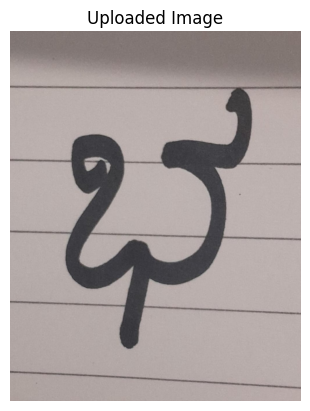

✅ Top-1: 039_bha → bha (84.83%)
🔹 Top-3 Predictions (refined):
 - 039_bha → bha (84.83%)
 - 061_bhru → bhru (9.80%)
 - 022_chha → chha (4.28%)


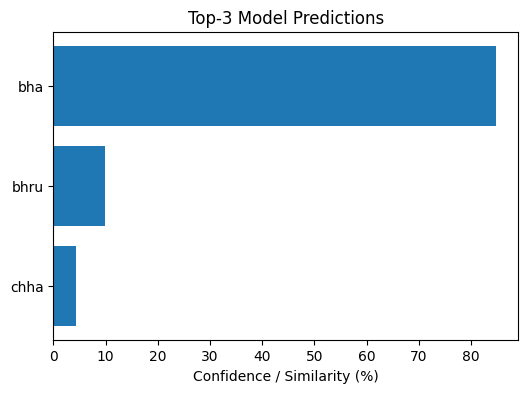


📁 All results logged to: logs/inference_results.csv
📤 Upload a Kannada handwritten word or sentence image:


Saving WhatsApp Image 2025-11-02 at 10.15.42 PM.jpeg to WhatsApp Image 2025-11-02 at 10.15.42 PM.jpeg

🔤 Running full OCR pipeline on: WhatsApp Image 2025-11-02 at 10.15.42 PM.jpeg


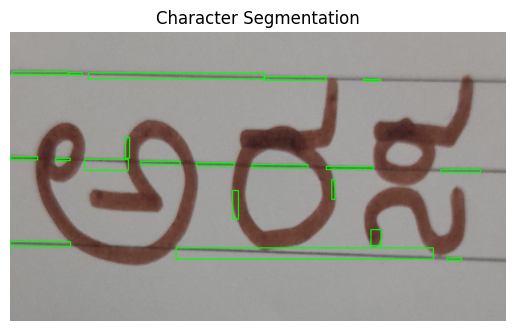

🧩 Detected 20 character(s) in 'WhatsApp Image 2025-11-02 at 10.15.42 PM.jpeg'.
  🔹 Character 1: tye (conf=22.39%)
  🔹 Character 2: hna (conf=34.60%)
  🔹 Character 3: hna (conf=55.32%)
  🔹 Character 4: hna (conf=35.25%)
  🔹 Character 5: hna (conf=68.46%)
  🔹 Character 6: gi (conf=79.78%)
  🔹 Character 7: hna (conf=21.04%)
  🔹 Character 8: hna (conf=74.33%)
  🔹 Character 9: hna (conf=35.62%)
  🔹 Character 10: gi (conf=62.08%)
  🔹 Character 11: hna (conf=34.51%)
  🔹 Character 12: hna (conf=55.43%)
  🔹 Character 13: tye (conf=17.07%)
  🔹 Character 14: mna (conf=17.02%)
  🔹 Character 15: mna (conf=19.87%)
  🔹 Character 16: hna (conf=74.76%)
  🔹 Character 17: hna (conf=69.65%)
  🔹 Character 18: hna (conf=51.39%)
  🔹 Character 19: hna (conf=64.38%)
  🔹 Character 20: hna (conf=69.27%)

✅ Recognized Word: tyehnahnahnahnagihnahnahnagihnahnatyemnamnahnahnahnahnahna


In [ ]:
# 📦 STEP 0 — Upload prerequisite model files
# ================================================
from google.colab import files
import os, json, torch, pandas as pd
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import csv
import torch.nn as nn


# --- Create directories if not exist
os.makedirs("project_files", exist_ok=True)
os.makedirs("diagnostics", exist_ok=True)
os.makedirs("logs", exist_ok=True)

print("📤 Upload the 3 required files:")
print("1️⃣ kannada_classifier_finetuned_full.pth")
print("2️⃣ classes_list_113.json")
print("3️⃣ centroid_top3_neighbors.csv")

uploaded = files.upload()

# --- Save uploaded files
for name in uploaded.keys():
    if name.endswith(".pth") or name.endswith(".json"):
        os.replace(name, f"project_files/{name}")
    elif name.endswith(".csv"):
        os.replace(name, f"diagnostics/{name}")

print("✅ All required files uploaded and stored.\n")

# ================================================
# 🧠 STEP 1 — Load Model and Metadata
# ================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint_path = "project_files/kannada_classifier_finetuned_full.pth"
ckpt = torch.load(checkpoint_path, map_location=device)
num_classes = ckpt.get("num_classes", 113)

# --- Define your model class
# (Replace with actual class if needed)
# Example placeholder:
# class KannadaClassifier(torch.nn.Module): ...
import torch
import torch.nn as nn
import timm

# ✅ KannadaClassifier definition (as used during training)
class KannadaClassifier(nn.Module):
    def __init__(self, backbone_name='swin_tiny_patch4_window7_224', embed_dim=512, num_classes=113):
        super().__init__()
        # Swin backbone from timm (no classification head)
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool='avg')

        feat_dim = self.backbone.num_features  # Swin-Tiny → 768
        self.fc_embed = nn.Linear(feat_dim, embed_dim)
        self.bn = nn.BatchNorm1d(embed_dim)
        self.dropout = nn.Dropout(0.35)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        feat = self.backbone(x)         # [B, feat_dim]
        emb = self.fc_embed(feat)       # [B, embed_dim]
        emb = self.bn(emb)
        emb = torch.relu(emb)
        emb = self.dropout(emb)
        logits = self.classifier(emb)
        return logits, emb


# ✅ Model instantiation
model = KannadaClassifier(num_classes=num_classes).to(device)
print("✅ Model created successfully.")




model = KannadaClassifier(num_classes=num_classes).to(device)
print("Model created. Classifier out_features:", model.classifier.out_features)
model.load_state_dict(ckpt["model_state_dict"], strict=False)
model.eval()
print("✅ Model loaded successfully.\n")

# --- Load classes list
with open("project_files/classes_list_113.json") as f:
    all_classes = json.load(f)

# --- Load centroids
centroids = None
try:
    df = pd.read_csv("diagnostics/centroid_top3_neighbors.csv")
    centroids = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32).to(device)
    print(f"✅ Loaded centroids for {centroids.shape[0]} classes.\n")
except Exception as e:
    print(f"⚠️ Centroid file not loaded: {e}")

# ================================================
# 🧩 STEP 2 — Define Transformations
# ================================================
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# ================================================
# 🔮 STEP 3 — Prediction + Logging Function
# ================================================
LOG_PATH = "logs/inference_results.csv"

# --- Initialize log CSV if not already created
if not os.path.exists(LOG_PATH):
    with open(LOG_PATH, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Image_Name", "Top1_Label", "Top1_Char", "Top1_Conf(%)",
                         "Top2_Label", "Top2_Char", "Top2_Conf(%)",
                         "Top3_Label", "Top3_Char", "Top3_Conf(%)"])

def predict_image(image_path, topk=3, use_centroids=True, log=True):
    image = Image.open(image_path).convert("RGB")
    tensor = val_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs, emb = model(tensor)
        probs = F.softmax(outputs, dim=1)
        top_probs, top_idxs = probs.topk(topk, dim=1)

    softmax_preds = [
        (all_classes[idx.item()], all_classes[idx.item()].split("_")[1], top_probs[0][i].item())
        for i, idx in enumerate(top_idxs[0])
    ]

    # --- Centroid refinement (optional)
    if use_centroids and centroids is not None:
        emb_norm = F.normalize(emb, dim=1)
        centroids_norm = F.normalize(centroids, dim=1)
        sims = torch.mm(emb_norm, centroids_norm.T).squeeze(0)
        top_sim_vals, top_sim_idxs = sims.topk(topk)
        centroid_preds = [
            (all_classes[idx.item()], all_classes[idx.item()].split("_")[1], top_sim_vals[i].item())
            for i, idx in enumerate(top_sim_idxs)
        ]
        refined = [softmax_preds[0]]
        for c in centroid_preds:
            if c[0] != refined[0][0]:
                refined.append(c)
            if len(refined) >= topk:
                break
        preds = refined
    else:
        preds = softmax_preds

    # --- Logging block
    if log:
        with open(LOG_PATH, "a", newline="") as f:
            writer = csv.writer(f)
            row = [os.path.basename(image_path)]
            for p in preds:
                row.extend([p[0], p[1], round(p[2]*100, 2)])
            # Fill missing columns if fewer than 3 preds
            while len(row) < 10:
                row.extend(["-", "-", "-"])
            writer.writerow(row)

    return preds

# ================================================
# 🖼️ STEP 4 — Upload and Predict on Unseen Image(s)
# ================================================
print("📤 Upload one or more unseen Kannada character images:")
uploaded_imgs = files.upload()

for img_name in uploaded_imgs.keys():
    print(f"\n🧾 Processing: {img_name}")
    img = Image.open(img_name).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.title("Uploaded Image")
    plt.show()

    top3 = predict_image(img_name, topk=3, use_centroids=True, log=True)

    print(f"✅ Top-1: {top3[0][0]} → {top3[0][1]} ({top3[0][2]*100:.2f}%)")
    print("🔹 Top-3 Predictions (refined):")
    for label, char, conf in top3:
        print(f" - {label} → {char} ({conf*100:.2f}%)")

    # Visualization
    plt.figure(figsize=(6,4))
    labels = [p[1] for p in top3]
    confidences = [p[2]*100 for p in top3]
    plt.barh(labels[::-1], confidences[::-1])
    plt.xlabel("Confidence / Similarity (%)")
    plt.title("Top-3 Model Predictions")
    plt.show()

print(f"\n📁 All results logged to: {LOG_PATH}")
# ================================================
# 🧩 STEP 5 — Word-Level OCR via Character Segmentation + Inference
# ================================================
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# --- Character segmentation using contours
def segment_word_image(image_path, min_area=50, debug=False):
    """
    Segment a handwritten word image into individual character crops.
    Returns a list of cropped PIL Images sorted left-to-right.
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding for better foreground separation
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 25, 15)

    # Morphological closing to connect disjoint character parts
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Find contours (each contour ≈ character region)
    contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if cv2.contourArea(c) > min_area:
            boxes.append((x, y, w, h))

    # Sort boxes by x coordinate (left to right)
    boxes = sorted(boxes, key=lambda x: x[0])

    char_images = []
    for (x, y, w, h) in boxes:
        char_crop = img[y:y+h, x:x+w]
        char_pil = Image.fromarray(cv2.cvtColor(char_crop, cv2.COLOR_BGR2RGB))
        char_images.append(char_pil)
        if debug:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)

    if debug:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Character Segmentation")
        plt.axis("off")
        plt.show()

    return char_images


# --- Word-level OCR using character model
def predict_word(image_path, topk=1, use_centroids=True, debug=False):
    """
    Performs OCR on a handwritten word image by segmenting characters,
    predicting each one with the Kannada classifier, and combining results.
    """
    char_crops = segment_word_image(image_path, debug=debug)
    print(f"🧩 Detected {len(char_crops)} character(s) in '{image_path}'.")

    predicted_chars = []
    for i, char_img in enumerate(char_crops):
        # Temporary save (for compatibility with predict_image)
        temp_path = f"temp_char_{i}.png"
        char_img.save(temp_path)

        preds = predict_image(temp_path, topk=topk, use_centroids=use_centroids, log=False)
        top_pred = preds[0][1]  # Extract the actual Kannada character
        predicted_chars.append(top_pred)

        print(f"  🔹 Character {i+1}: {top_pred} (conf={preds[0][2]*100:.2f}%)")

    # Combine recognized characters into word
    word_pred = "".join(predicted_chars)
    print(f"\n✅ Recognized Word: {word_pred}")
    return word_pred


# ================================================
# 🧮 STEP 6 — Optional Line-Level OCR
# ================================================
def segment_lines(image_path, min_line_height=20, debug=False):
    """
    Segment a full-page or multi-line text image into individual word/line crops.
    Returns list of cropped PIL Images (line-level).
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Horizontal projection for line segmentation
    hist = np.sum(binary, axis=1)
    h, w = binary.shape
    lines = []
    in_line = False
    start_y = 0

    for y in range(h):
        if hist[y] > min_line_height and not in_line:
            in_line = True
            start_y = y
        elif hist[y] <= min_line_height and in_line:
            in_line = False
            end_y = y
            line_crop = img[start_y:end_y, :]
            if end_y - start_y > min_line_height:
                lines.append(line_crop)

    if debug:
        vis = img.copy()
        for i, lc in enumerate(lines):
            y1, y2 = np.where(hist > min_line_height)[0][[0, -1]]
            cv2.rectangle(vis, (0, start_y), (w, end_y), (0,255,0), 2)
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.title("Line Segmentation")
        plt.axis("off")
        plt.show()

    return [Image.fromarray(cv2.cvtColor(l, cv2.COLOR_BGR2RGB)) for l in lines]


def predict_line(image_path, debug=False):
    """
    Recognize an entire line or multiple words by splitting into words,
    segmenting characters within each, and merging all recognized words.
    """
    line_crops = segment_lines(image_path, debug=debug)
    full_text = []

    for i, line_img in enumerate(line_crops):
        # Save temporary line
        temp_path = f"temp_line_{i}.png"
        line_img.save(temp_path)
        word_text = predict_word(temp_path, debug=False)
        full_text.append(word_text)

    full_output = " ".join(full_text)
    print(f"\n🧠 Full Line Recognition: {full_output}")
    return full_output


# ================================================
# 🧪 STEP 7 — Try with Word or Line Image
# ================================================
print("📤 Upload a Kannada handwritten word or sentence image:")
uploaded_word_imgs = files.upload()

for img_name in uploaded_word_imgs.keys():
    print(f"\n🔤 Running full OCR pipeline on: {img_name}")
    predict_word(img_name, topk=1, use_centroids=True, debug=True)


In [ ]:
# ================================================
# 🧠 STEP 8 — Progressive Word Fragmentation OCR (2–5 splits)
# ================================================
import math

def progressive_word_segmentation(image_path, max_splits=5, debug=True):
    """
    Try splitting the uploaded word image into 2–5 equal-width fragments,
    run character recognition on each, and print merged word hypotheses.
    """
    img = cv2.imread(image_path)
    h, w, _ = img.shape

    print(f"\n🧩 Progressive Word Segmentation for '{os.path.basename(image_path)}'")
    print(f"Original Image Size: {w}x{h}px")

    # Visualize original word
    if debug:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original Word Image")
        plt.axis("off")
        plt.show()

    # Try multiple segmentation levels (2 to 5)
    for splits in range(2, max_splits + 1):
        print(f"\n🔹 Attempting segmentation into {splits} parts...")
        seg_width = w // splits
        predicted_chars = []

        # Cut image into equal-width segments
        for i in range(splits):
            x1 = i * seg_width
            x2 = (i + 1) * seg_width if i < splits - 1 else w
            char_crop = img[:, x1:x2]

            # Convert to PIL for predict_image()
            char_pil = Image.fromarray(cv2.cvtColor(char_crop, cv2.COLOR_BGR2RGB))
            temp_path = f"temp_split_{splits}_{i}.png"
            char_pil.save(temp_path)

            preds = predict_image(temp_path, topk=3, use_centroids=True, log=False)
            top_pred = preds[0][1]  # best Kannada character
            predicted_chars.append(top_pred)

            print(f"  ✳️ Segment {i+1}: {top_pred} ({preds[0][2]*100:.2f}% conf)")
            print(f"     Top-3: {[p[1] for p in preds]}")

        # Merge characters into full word hypothesis
        merged_word = "".join(predicted_chars)
        print(f"\n✅ Hypothesis (split={splits}): {merged_word}")

        # Visual boundary overlay
        if debug:
            vis = img.copy()
            for i in range(1, splits):
                x = i * seg_width
                cv2.line(vis, (x, 0), (x, h), (255, 0, 0), 2)
            plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
            plt.title(f"{splits}-part segmentation")
            plt.axis("off")
            plt.show()

    print("\n🧠 Progressive segmentation finished.")


📤 Upload a Kannada handwritten word image:


Saving WhatsApp Image 2025-11-02 at 10.32.30 PM.jpeg to WhatsApp Image 2025-11-02 at 10.32.30 PM.jpeg

🧩 Progressive Word Segmentation for 'WhatsApp Image 2025-11-02 at 10.32.30 PM.jpeg'
Original Image Size: 1446x563px


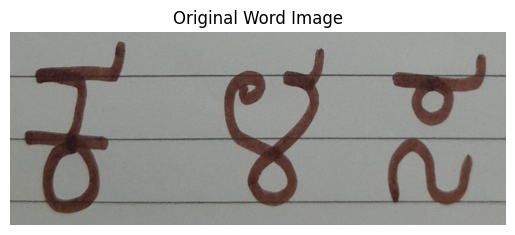


🔹 Attempting segmentation into 2 parts...
  ✳️ Segment 1: she (41.32% conf)
     Top-3: ['she', 'ka', 'bha']
  ✳️ Segment 2: saa (76.31% conf)
     Top-3: ['saa', 'plau', 'l2aha']

✅ Hypothesis (split=2): shesaa


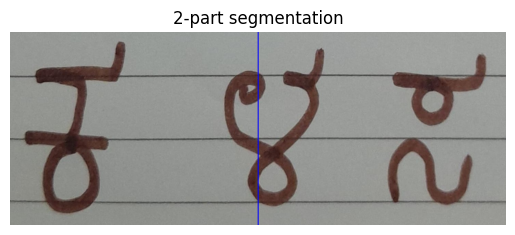


🔹 Attempting segmentation into 3 parts...
  ✳️ Segment 1: ka (99.23% conf)
     Top-3: ['ka', 'she', 'ra']
  ✳️ Segment 2: lla (91.77% conf)
     Top-3: ['lla', 'l2aha', 'lla']
  ✳️ Segment 3: saa (75.28% conf)
     Top-3: ['saa', 'su', 'ne']

✅ Hypothesis (split=3): kallasaa


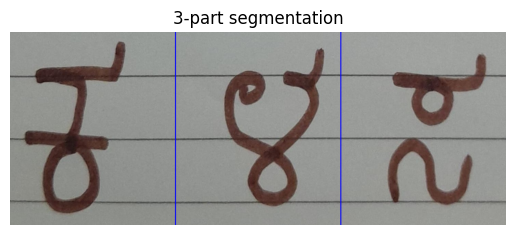


🔹 Attempting segmentation into 4 parts...
  ✳️ Segment 1: ka (97.04% conf)
     Top-3: ['ka', 'she', 'ra']
  ✳️ Segment 2: plau (9.18% conf)
     Top-3: ['plau', 'lee', 'la']
  ✳️ Segment 3: l2aha (95.07% conf)
     Top-3: ['l2aha', 'lla', 'plau']
  ✳️ Segment 4: su (50.78% conf)
     Top-3: ['su', 'saa', 'sa']

✅ Hypothesis (split=4): kaplaul2ahasu


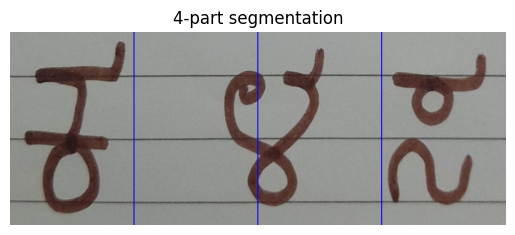


🔹 Attempting segmentation into 5 parts...
  ✳️ Segment 1: ka (96.97% conf)
     Top-3: ['ka', 'ra', 'she']
  ✳️ Segment 2: jai (13.90% conf)
     Top-3: ['jai', 'ga', 'bhru']
  ✳️ Segment 3: l2aha (81.43% conf)
     Top-3: ['l2aha', 'lla', 'shna']
  ✳️ Segment 4: ga (32.11% conf)
     Top-3: ['ga', 'goo', 'saa']
  ✳️ Segment 5: ska (43.13% conf)
     Top-3: ['ska', 'saa', 'su']

✅ Hypothesis (split=5): kajail2ahagaska


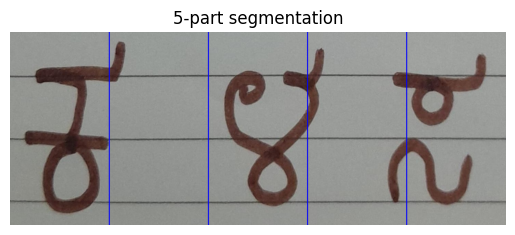


🧠 Progressive segmentation finished.


In [ ]:
print("📤 Upload a Kannada handwritten word image:")
uploaded_prog_imgs = files.upload()

for img_name in uploaded_prog_imgs.keys():
    progressive_word_segmentation(img_name, max_splits=5, debug=True)


📤 Upload a Kannada handwritten word image:


Saving WhatsApp Image 2025-11-02 at 11.01.32 PM.jpeg to WhatsApp Image 2025-11-02 at 11.01.32 PM.jpeg

🧩 Progressive Word Segmentation for 'WhatsApp Image 2025-11-02 at 11.01.32 PM.jpeg'
Original Image Size: 1600x506px


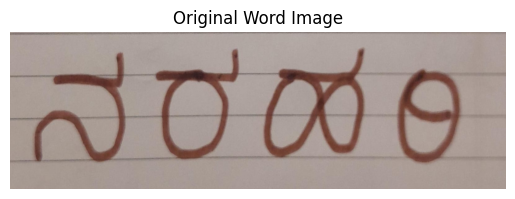


🔹 Attempting segmentation into 2 parts...
  ✳️ Segment 1: yau (89.22% conf)
     Top-3: ['yau', 'goo', 'maa']
  ✳️ Segment 2: yau (38.31% conf)
     Top-3: ['yau', 'saa', 'haha']

✅ Hypothesis (split=2): yauyau


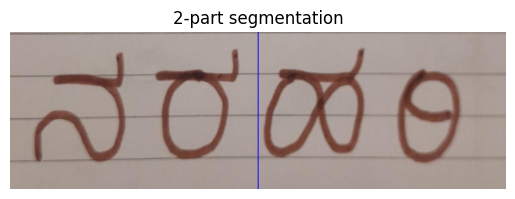


🔹 Attempting segmentation into 3 parts...
  ✳️ Segment 1: ne (68.24% conf)
     Top-3: ['ne', 'goo', 'yau']
  ✳️ Segment 2: ii (52.96% conf)
     Top-3: ['ii', 'haha', 'sha']
  ✳️ Segment 3: ri (27.60% conf)
     Top-3: ['ri', 'plau', 'ru']

✅ Hypothesis (split=3): neiiri


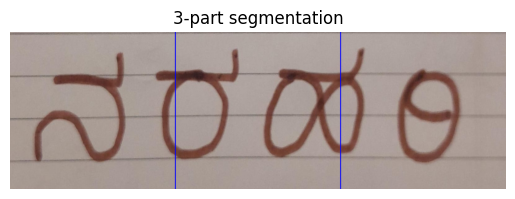


🔹 Attempting segmentation into 4 parts...
  ✳️ Segment 1: na (43.40% conf)
     Top-3: ['na', 'ne', 'goo']
  ✳️ Segment 2: ra (31.87% conf)
     Top-3: ['ra', 'ra', 'ri']
  ✳️ Segment 3: haha (93.23% conf)
     Top-3: ['haha', 'ii', 'sha']
  ✳️ Segment 4: ri (97.59% conf)
     Top-3: ['ri', 'lee', 'plau']

✅ Hypothesis (split=4): narahahari


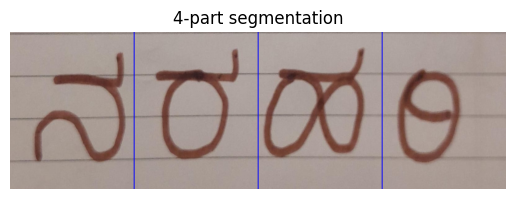


🔹 Attempting segmentation into 5 parts...
  ✳️ Segment 1: gam (49.79% conf)
     Top-3: ['gam', 'ne', 'goo']
  ✳️ Segment 2: ra (32.15% conf)
     Top-3: ['ra', 'ra', 'jai']
  ✳️ Segment 3: ri (22.32% conf)
     Top-3: ['ri', 'ra', 'plau']
  ✳️ Segment 4: haha (51.11% conf)
     Top-3: ['haha', 'ii', 'sha']
  ✳️ Segment 5: ri (79.08% conf)
     Top-3: ['ri', 'plau', 'i']

✅ Hypothesis (split=5): gamrarihahari


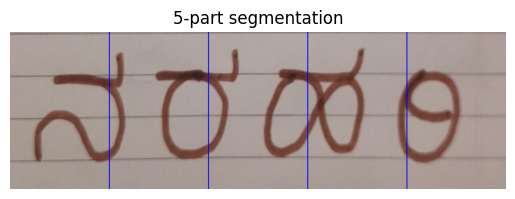


🧠 Progressive segmentation finished.


In [ ]:
print("📤 Upload a Kannada handwritten word image:")
uploaded_prog_imgs = files.upload()

for img_name in uploaded_prog_imgs.keys():
    progressive_word_segmentation(img_name, max_splits=5, debug=True)

FINAL INFERENCE PIPELINE

In [ ]:
# ================================================
# 📦 STEP 0 — Upload prerequisite model files
# ================================================
from google.colab import files
import os, json, torch, pandas as pd

# --- Create required folders
os.makedirs("project_files", exist_ok=True)
os.makedirs("diagnostics", exist_ok=True)
os.makedirs("logs", exist_ok=True)

print("📤 Upload the 3 required files:")
print("1️⃣ kannada_classifier_finetuned_full (1).pth")
print("2️⃣ classes_list_113_kannada (1).json")
print("3️⃣ centroid_top3_neighbors (1).csv")

uploaded = files.upload()

# --- Move uploaded files into proper project structure
for name in uploaded.keys():
    if name.startswith("kannada_classifier_finetuned_full") and name.endswith(".pth"):
        os.replace(name, "project_files/kannada_classifier_finetuned_full.pth")
    elif name.startswith("classes_list_113_kannada") and name.endswith(".json"):
        os.replace(name, "project_files/classes_list_113_kannada.json")
    elif name.startswith("centroid_top3_neighbors") and name.endswith(".csv"):
        os.replace(name, "diagnostics/centroid_top3_neighbors.csv")

print("\n✅ All required files uploaded and saved successfully!")
!ls project_files
!ls diagnostics


📤 Upload the 3 required files:
1️⃣ kannada_classifier_finetuned_full (1).pth
2️⃣ classes_list_113_kannada (1).json
3️⃣ centroid_top3_neighbors (1).csv


Saving kannada_classifier_finetuned_full (1).pth to kannada_classifier_finetuned_full (1).pth
Saving centroid_top3_neighbors (1).csv to centroid_top3_neighbors (1).csv
Saving classes_list_113_kannada (1).json to classes_list_113_kannada (1).json

✅ All required files uploaded and saved successfully!
'classes_list_113_kannada (1).json'
 classes_list_113_kannada.json
'kannada_classifier_finetuned_full (1).pth'
 kannada_classifier_finetuned_full.pth
'centroid_top3_neighbors (1).csv'   centroid_top3_neighbors.csv


In [ ]:
# ================================================
# 🧠 STEP 1 — Load Model and Metadata
# ================================================
import torch, torch.nn as nn, timm
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import pandas as pd
import csv, os

device = "cuda" if torch.cuda.is_available() else "cpu"

CKPT_PATH = "project_files/kannada_classifier_finetuned_full.pth"
CLASSES_PATH = "project_files/classes_list_113_kannada.json"
CENTROID_PATH = "diagnostics/centroid_top3_neighbors.csv"
LOG_PATH = "logs/inference_results.csv"

# --- Define KannadaClassifier (Swin Backbone)
class KannadaClassifier(nn.Module):
    def __init__(self, backbone_name='swin_tiny_patch4_window7_224', embed_dim=512, num_classes=113):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool='avg')
        feat_dim = self.backbone.num_features  # Swin-Tiny → 768
        self.fc_embed = nn.Linear(feat_dim, embed_dim)
        self.bn = nn.BatchNorm1d(embed_dim)
        self.dropout = nn.Dropout(0.35)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        feat = self.backbone(x)
        emb = self.fc_embed(feat)
        emb = self.bn(emb)
        emb = torch.relu(emb)
        emb = self.dropout(emb)
        logits = self.classifier(emb)
        return logits, emb

# --- Load checkpoint and instantiate model
ckpt = torch.load(CKPT_PATH, map_location=device)
num_classes = ckpt.get("num_classes", 113)

model = KannadaClassifier(num_classes=num_classes).to(device)
model.load_state_dict(ckpt["model_state_dict"], strict=False)
model.eval()
print("✅ Model loaded successfully.")

# --- Load class list
with open(CLASSES_PATH, "r") as f:
    all_classes = json.load(f)

# --- Load centroids
centroids = None
try:
    df = pd.read_csv(CENTROID_PATH)
    centroids = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32).to(device)
    print(f"✅ Loaded centroids for {centroids.shape[0]} classes.")
except Exception as e:
    print(f"⚠️ Centroids not loaded: {e}")

# --- Image transforms
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# --- Initialize log file
if not os.path.exists(LOG_PATH):
    with open(LOG_PATH, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "Image_Name", "Top1_Label", "Top1_Char", "Top1_Conf(%)",
            "Top2_Label", "Top2_Char", "Top2_Conf(%)",
            "Top3_Label", "Top3_Char", "Top3_Conf(%)"
        ])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

✅ Model loaded successfully.
⚠️ Centroids not loaded: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.


In [ ]:
# ================================================
# 🔮 STEP 2 — Prediction Function
# ================================================
def predict_image(image_path, topk=3, use_centroids=True, log=True):
    image = Image.open(image_path).convert("RGB")
    tensor = val_transforms(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs, emb = model(tensor)
        probs = F.softmax(outputs, dim=1)
        top_probs, top_idxs = probs.topk(topk, dim=1)

    softmax_preds = [
        (all_classes[idx.item()], all_classes[idx.item()].split("_")[1], top_probs[0][i].item())
        for i, idx in enumerate(top_idxs[0])
    ]

    # --- Centroid refinement (optional)
    if use_centroids and centroids is not None:
        emb_norm = F.normalize(emb, dim=1)
        centroids_norm = F.normalize(centroids, dim=1)
        sims = torch.mm(emb_norm, centroids_norm.T).squeeze(0)
        top_sim_vals, top_sim_idxs = sims.topk(topk)
        centroid_preds = [
            (all_classes[idx.item()], all_classes[idx.item()].split("_")[1], top_sim_vals[i].item())
            for i, idx in enumerate(top_sim_idxs)
        ]
        refined = [softmax_preds[0]]
        for c in centroid_preds:
            if c[0] != refined[0][0]:
                refined.append(c)
            if len(refined) >= topk:
                break
        preds = refined
    else:
        preds = softmax_preds

    # --- Log prediction
    if log:
        with open(LOG_PATH, "a", newline="") as f:
            writer = csv.writer(f)
            row = [os.path.basename(image_path)]
            for p in preds:
                row.extend([p[0], p[1], round(p[2]*100, 2)])
            while len(row) < 10:
                row.extend(["-", "-", "-"])
            writer.writerow(row)

    return preds


In [ ]:
# ================================================
# 🧩 STEP 3 — Progressive Word Fragmentation OCR
# ================================================
import cv2, matplotlib.pyplot as plt

def progressive_word_segmentation(image_path, max_splits=5, debug=True):
    img = cv2.imread(image_path)
    h, w, _ = img.shape

    print(f"\n🧩 Progressive Segmentation: {os.path.basename(image_path)} ({w}x{h})")

    if debug:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original Word Image")
        plt.axis("off")
        plt.show()

    for splits in range(2, max_splits + 1):
        print(f"\n🔹 Trying {splits} parts ...")
        seg_width = w // splits
        predicted_chars = []

        for i in range(splits):
            x1, x2 = i * seg_width, (i + 1) * seg_width if i < splits - 1 else w
            crop = img[:, x1:x2]
            temp_path = f"temp_split_{splits}_{i}.png"
            Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)).save(temp_path)
            preds = predict_image(temp_path, log=False)
            predicted_chars.append(preds[0][1])
            print(f"  ✳️ Segment {i+1}: {preds[0][1]} ({preds[0][2]*100:.2f}%)")

        word = "".join(predicted_chars)
        print(f"✅ Hypothesis (split={splits}): {word}")

        if debug:
            vis = img.copy()
            for i in range(1, splits):
                cv2.line(vis, (i*seg_width, 0), (i*seg_width, h), (255, 0, 0), 2)
            plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
            plt.title(f"{splits}-part segmentation")
            plt.axis("off")
            plt.show()


In [ ]:
# ================================================
# 🎛️ STEP 4 — Gradio Interface for Kannada OCR
# ================================================
import gradio as gr
import io, matplotlib.pyplot as plt
from PIL import Image

def recognize_kannada(image):
    image = image.resize((224, 224))
    temp_path = "temp_infer.png"
    image.save(temp_path)

    top3 = predict_image(temp_path, topk=3, use_centroids=True, log=True)
    top1_label, top1_char, top1_conf = top3[0]

    result_html = (
        f"<h2 style='color:#1A73E8;'>✅ Top-1 Prediction:</h2>"
        f"<h1 style='font-size:32px;'>{top1_char}</h1>"
        f"<p>Confidence: {top1_conf*100:.2f}%</p><br>"
        f"<h3>🔹 Top-3 Predictions</h3>"
    )
    for label, char, conf in top3:
        result_html += f"<p>• {char} ({conf*100:.2f}%)</p>"

    labels = [p[1] for p in top3]
    confidences = [p[2]*100 for p in top3]
    plt.figure(figsize=(4.5, 2.5))
    plt.barh(labels[::-1], confidences[::-1])
    plt.xlabel("Confidence (%)")
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    chart = Image.open(buf)

    return result_html, chart

def recognize_kannada_word(image):
    temp_path = "temp_word.png"
    image.save(temp_path)
    progressive_word_segmentation(temp_path, max_splits=5, debug=False)
    return "✅ Word segmentation completed — check console for details."

# --- Interface with two tabs
with gr.Blocks(theme="default") as demo:
    gr.Markdown("## 🪶 Kannada Handwritten OCR (Swin Transformer)")

    with gr.Tab("🔤 Character Recognition"):
        gr.Markdown("Upload a single Kannada character image.")
        img_in = gr.Image(type="pil", label="Character Image (224×224 resized)")
        res_html = gr.HTML()
        res_chart = gr.Image(label="Confidence Distribution", show_label=False)
        btn = gr.Button("🔍 Predict Character")
        btn.click(fn=recognize_kannada, inputs=img_in, outputs=[res_html, res_chart])

    with gr.Tab("🪔 Word Recognition"):
        gr.Markdown("Upload a handwritten Kannada word image to auto-segment and predict.")
        word_in = gr.Image(type="pil", label="Word Image")
        word_out = gr.Textbox(label="Segmentation Result Log")
        btn2 = gr.Button("🧩 Run Word OCR")
        btn2.click(fn=recognize_kannada_word, inputs=word_in, outputs=word_out)

demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://33dd96b1cec2f75df8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-4061984526.py:30: UserWarning: Glyph 3227 (\N{KANNADA LETTER CHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4061984526.py:30: UserWarning: Matplotlib currently does not support Kannada natively.
  plt.tight_layout()
/tmp/ipython-input-4061984526.py:30: UserWarning: Glyph 3245 (\N{KANNADA LETTER BHA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4061984526.py:30: UserWarning: Glyph 3267 (\N{KANNADA VOWEL SIGN VOCALIC R}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4061984526.py:32: UserWarning: Glyph 3227 (\N{KANNADA LETTER CHA}) missing from font(s) DejaVu Sans.
  plt.savefig(buf, format='png')
/tmp/ipython-input-4061984526.py:32: UserWarning: Matplotlib currently does not support Kannada natively.
  plt.savefig(buf, format='png')
/tmp/ipython-input-4061984526.py:32: UserWarning: Glyph 3245 (\N{KANNADA LETTER BHA}) missing from font(s) DejaVu Sans.
  plt.savefig(buf, format='p


🧩 Progressive Segmentation: temp_word.png (1600x506)

🔹 Trying 2 parts ...
  ✳️ Segment 1: ಯೌ (89.22%)
  ✳️ Segment 2: ಯೌ (38.31%)
✅ Hypothesis (split=2): ಯೌಯೌ

🔹 Trying 3 parts ...
  ✳️ Segment 1: ನೆ (68.24%)
  ✳️ Segment 2: ಈ (52.96%)
  ✳️ Segment 3: ರಿ (27.60%)
✅ Hypothesis (split=3): ನೆಈರಿ

🔹 Trying 4 parts ...
  ✳️ Segment 1: ನ (43.40%)
  ✳️ Segment 2: ರ್ರ (31.87%)
  ✳️ Segment 3: ಹಃ (93.23%)
  ✳️ Segment 4: ರಿ (97.59%)
✅ Hypothesis (split=4): ನರ್ರಹಃರಿ

🔹 Trying 5 parts ...
  ✳️ Segment 1: ಗಂ (49.79%)
  ✳️ Segment 2: ರ (32.15%)
  ✳️ Segment 3: ರಿ (22.32%)
  ✳️ Segment 4: ಹಃ (51.11%)
  ✳️ Segment 5: ರಿ (79.08%)
✅ Hypothesis (split=5): ಗಂರರಿಹಃರಿ

🧩 Progressive Segmentation: temp_word.png (1600x506)

🔹 Trying 2 parts ...
  ✳️ Segment 1: ಯೌ (89.22%)
  ✳️ Segment 2: ಯೌ (38.31%)
✅ Hypothesis (split=2): ಯೌಯೌ

🔹 Trying 3 parts ...
  ✳️ Segment 1: ನೆ (68.24%)
  ✳️ Segment 2: ಈ (52.96%)
  ✳️ Segment 3: ರಿ (27.60%)
✅ Hypothesis (split=3): ನೆಈರಿ

🔹 Trying 4 parts ...
  ✳️ Segment 1: ನ (43.40

In [ ]:
# ================================================
# 🎛️ STEP 4 — Gradio Interface for Kannada OCR
# ================================================
import gradio as gr
import io, matplotlib.pyplot as plt
from PIL import Image
import cv2

# --- Updated word segmentation that returns string summary
def progressive_word_segmentation(image_path, max_splits=5, debug=False):
    """
    Try splitting the uploaded word image into 2–5 equal-width fragments,
    run character recognition on each, and return merged word hypotheses.
    """
    img = cv2.imread(image_path)
    if img is None:
        return "❌ Error: Could not read image."

    h, w, _ = img.shape
    summary = f"🧩 Progressive Word Segmentation for '{os.path.basename(image_path)}'\n"
    summary += f"Image Size: {w}x{h}px\n\n"

    for splits in range(2, max_splits + 1):
        summary += f"🔹 Attempting segmentation into {splits} parts...\n"
        seg_width = w // splits
        predicted_chars = []

        for i in range(splits):
            x1, x2 = i * seg_width, (i + 1) * seg_width if i < splits - 1 else w
            char_crop = img[:, x1:x2]
            char_pil = Image.fromarray(cv2.cvtColor(char_crop, cv2.COLOR_BGR2RGB))
            temp_path = f"temp_split_{splits}_{i}.png"
            char_pil.save(temp_path)

            preds = predict_image(temp_path, topk=3, use_centroids=True, log=False)
            top_pred = preds[0][1]  # best Kannada character
            predicted_chars.append(top_pred)

            # Append segment details to text output
            top3_str = ", ".join([f"{p[1]} ({p[2]*100:.2f}%)" for p in preds])
            summary += f"  ✳️ Segment {i+1}: {top_pred} → [{top3_str}]\n"

        merged_word = "".join(predicted_chars)
        summary += f"✅ Hypothesis (split={splits}): {merged_word}\n\n"

    summary += "🧠 Progressive segmentation finished."
    return summary


# --- Character-level recognition
def recognize_kannada(image):
    image = image.resize((224, 224))
    temp_path = "temp_infer.png"
    image.save(temp_path)

    top3 = predict_image(temp_path, topk=3, use_centroids=True, log=True)
    top1_label, top1_char, top1_conf = top3[0]

    # Build HTML result block
    result_html = (
        f"<h2 style='color:#1A73E8;'>✅ Top-1 Prediction:</h2>"
        f"<h1 style='font-size:32px;'>{top1_char}</h1>"
        f"<p>Confidence: {top1_conf*100:.2f}%</p><br>"
        f"<h3>🔹 Top-3 Predictions</h3>"
    )
    for label, char, conf in top3:
        result_html += f"<p>• {char} ({conf*100:.2f}%)</p>"

    # Plot bar chart of confidences
    labels = [p[1] for p in top3]
    confidences = [p[2]*100 for p in top3]
    plt.figure(figsize=(4.5, 2.5))
    plt.barh(labels[::-1], confidences[::-1])
    plt.xlabel("Confidence (%)")
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    chart = Image.open(buf)

    return result_html, chart


# --- Word-level recognition (now returns formatted output)
def recognize_kannada_word(image):
    temp_path = "temp_word.png"
    image.save(temp_path)
    result_summary = progressive_word_segmentation(temp_path, max_splits=5, debug=False)
    return result_summary


# --- Interface with two tabs
with gr.Blocks(theme="default") as demo:
    gr.Markdown("## 🪶 Kannada Handwritten OCR (Swin Transformer)")

    # --- Character OCR tab
    with gr.Tab("🔤 Character Recognition"):
        gr.Markdown("Upload a single Kannada character image.")
        img_in = gr.Image(type="pil", label="Character Image (224×224 resized)")
        res_html = gr.HTML()
        res_chart = gr.Image(label="Confidence Distribution", show_label=False)
        btn = gr.Button("🔍 Predict Character")
        btn.click(fn=recognize_kannada, inputs=img_in, outputs=[res_html, res_chart])

    # --- Word OCR tab
    with gr.Tab("🪔 Word Recognition"):
        gr.Markdown("Upload a handwritten Kannada word image for auto-segmentation & prediction.")
        word_in = gr.Image(type="pil", label="Word Image")
        word_out = gr.Textbox(label="Segmentation Result Log", lines=15)
        btn2 = gr.Button("🧩 Run Word OCR")
        btn2.click(fn=recognize_kannada_word, inputs=word_in, outputs=word_out)

demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4be6d709355e67be5f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",